# Definitions

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
os.environ['OMP_NUM_THREADS'] = '8'
import matplotlib
import math
from matplotlib import pyplot as plt
import numpy as np
import euclidemu2
import scipy
import cosmolike_lsst_y1_interface as ci
from getdist import IniFile
import itertools
import iminuit
import functools
print(sys.version)
print(os.getcwd())

# GENERAL PLOT OPTIONS
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['xtick.bottom'] = True
matplotlib.rcParams['xtick.top'] = False
matplotlib.rcParams['ytick.right'] = False
matplotlib.rcParams['axes.edgecolor'] = 'black'
matplotlib.rcParams['axes.linewidth'] = '1.0'
matplotlib.rcParams['axes.labelsize'] = 'medium'
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.linewidth'] = '0.0'
matplotlib.rcParams['grid.alpha'] = '0.18'
matplotlib.rcParams['grid.color'] = 'lightgray'
matplotlib.rcParams['legend.labelspacing'] = 0.77
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['savefig.format'] = 'pdf'
matplotlib.rcParams['text.usetex'] = True

# Jupyter Notebook Display options
import IPython
IPython.display.display(IPython.display.HTML("<style>:root { --jp-notebook-max-width: 85% !important; }</style>"))
IPython.display.display(IPython.display.HTML("<style>div.output_scroll { height: 54em; }</style>"))

3.9.19 | packaged by conda-forge | (main, Mar 20 2024, 12:50:21) 
[GCC 12.3.0]
/home/vivianmiranda/extra_data/Vivian/cocoa2025/cocoa/Cocoa/projects/lsst_y1


In [2]:
# IMPORT CAMB
sys.path.insert(0, os.environ['ROOTDIR']+'/external_modules/code/CAMB/build/lib.linux-x86_64-'+os.environ['PYTHON_VERSION'])
import camb
from camb import model
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.5.5 installed at /home/vivianmiranda/extra_data/Vivian/cocoa2025/cocoa/Cocoa/external_modules/code/CAMB/build/lib.linux-x86_64-3.9/camb


In [3]:
CAMBAccuracyBoost = 1.1
non_linear_emul = 2
CLprobe="3x2pt"

path= "../../external_modules/data/lsst_y1"
data_file="lsst_y1_M1_GGL0.05.dataset"

IA_model = 0
IA_redshift_evolution = 3

ntheta = 26 
theta_min_arcmin = 2.5 
theta_max_arcmin = 900

In [4]:
As_1e9 = 2.1
ns = 0.96605
H0 = 67.32
omegab = 0.04
omegam = 0.3
mnu = 0.06
LSST_DZ_S1 = 0.0414632
LSST_DZ_S2 = 0.00147332
LSST_DZ_S3 = 0.0237035
LSST_DZ_S4 = -0.0773436
LSST_DZ_S5 = -8.67127e-05
LSST_M1 = 0.0191832
LSST_M2 = -0.0431752
LSST_M3 = -0.034961
LSST_M4 = -0.0158096
LSST_M5 = -0.0158096
LSST_A1_1 = 0.606102
LSST_A1_2 = -1.51541
LSST_DZ_L1 = 0.00457604
LSST_DZ_L2 = 0.000309875
LSST_DZ_L3 = 0.00855907
LSST_DZ_L4 = -0.00316269
LSST_DZ_L5 = -0.0146753 
LSST_B1_1 = 1.72716
LSST_B1_2 = 1.65168
LSST_B1_3 = 1.61423
LSST_B1_4 = 1.92886
LSST_B1_5 = 2.11633
LSST_PM_1 = 0.0
LSST_PM_2 = 0.0
LSST_PM_3 = 0.0
LSST_PM_4 = 0.0
LSST_PM_5 = 0.0
w0pwa = -0.9
w = -0.9

In [5]:
def get_camb_cosmology(omegam = omegam, omegab = omegab, H0 = H0, ns = ns, 
                       As_1e9 = As_1e9, w = w, w0pwa = w0pwa, AccuracyBoost = 1.0, 
                       kmax = 10, k_per_logint = 20, CAMBAccuracyBoost=1.1):

    As = lambda As_1e9: 1e-9 * As_1e9
    wa = lambda w0pwa, w: w0pwa - w
    omegabh2 = lambda omegab, H0: omegab*(H0/100)**2
    omegach2 = lambda omegam, omegab, mnu, H0: (omegam-omegab)*(H0/100)**2-(mnu*(3.046/3)**0.75)/94.0708
    omegamh2 = lambda omegam, H0: omegam*(H0/100)**2

    CAMBAccuracyBoost = CAMBAccuracyBoost*AccuracyBoost
    kmax = max(kmax/2.0, kmax*(1.0 + 3*(AccuracyBoost-1)))
    k_per_logint = max(k_per_logint/2.0, int(k_per_logint) + int(3*(AccuracyBoost-1)))
    extrap_kmax = max(max(2.5e2, 3*kmax), max(2.5e2, 3*kmax) * AccuracyBoost)

    z_interp_1D = np.concatenate( (np.concatenate( (np.linspace(0,2.0,1000),
                                                    np.linspace(2.0,10.1,200)),
                                                    axis=0
                                                 ),
                                   np.linspace(1080,2000,20)),
                                   axis=0)
    
    z_interp_2D = np.concatenate((np.linspace(0, 2.0, 120), np.linspace(2.01, 10, 30)),  axis=0)

    log10k_interp_2D = np.linspace(-4.2, 2.0, 1400)

    pars = camb.set_params(H0=H0, 
                           ombh2=omegabh2(omegab, H0), 
                           omch2=omegach2(omegam, omegab, mnu, H0), 
                           mnu=mnu, 
                           omk=0, 
                           tau=0.06,  
                           As=As(As_1e9), 
                           ns=ns, 
                           halofit_version='takahashi', 
                           lmax=10,
                           AccuracyBoost=CAMBAccuracyBoost,
                           lens_potential_accuracy=1.0,
                           num_massive_neutrinos=1,
                           nnu=3.046,
                           accurate_massive_neutrino_transfers=False,
                           k_per_logint=k_per_logint,
                           kmax = kmax);
    
    pars.set_dark_energy(w=w, wa=wa(w0pwa, w), dark_energy_model='ppf');    
    
    pars.NonLinear = model.NonLinear_both
    
    pars.set_matter_power(redshifts = z_interp_2D, kmax = kmax, silent = True);
    results = camb.get_results(pars)
    
    PKL  = results.get_matter_power_interpolator(var1="delta_tot", var2="delta_tot", nonlinear = False, 
                                                 extrap_kmax = extrap_kmax, hubble_units = False, k_hunit = False);
    
    PKNL = results.get_matter_power_interpolator(var1="delta_tot", var2="delta_tot",  nonlinear = True, 
                                                 extrap_kmax = extrap_kmax, hubble_units = False, k_hunit = False);
    
    lnPL = np.empty(len(log10k_interp_2D)*len(z_interp_2D))
    for i in range(len(z_interp_2D)):
        lnPL[i::len(z_interp_2D)] = np.log(PKL.P(z_interp_2D[i], np.power(10.0,log10k_interp_2D)))
    lnPL  += np.log(((H0/100.)**3)) 
    
    lnPNL  = np.empty(len(log10k_interp_2D)*len(z_interp_2D))
    if non_linear_emul == 1:
        params = { 'Omm'  : omegam, 
                   'As'   : As(As_1e9), 
                   'Omb'  : omegab,
                   'ns'   : ns, 
                   'h'    : H0/100., 
                   'mnu'  : mnu,  
                   'w'    : w, 
                   'wa'   : wa(w0pwa, w)
                 }
        kbt, bt = euclidemu2.get_boost( params, 
                                        z_interp_2D, 
                                        np.power(10.0, np.linspace( -2.0589, 0.973, len(log10k_interp_2D)))
                                      )
        log10k_interp_2D = log10k_interp_2D - np.log10(H0/100.)
        
        for i in range(len(z_interp_2D)):    
            lnbt = scipy.interpolate.interp1d(np.log10(kbt), np.log(bt[i]), kind = 'linear', 
                                              fill_value = 'extrapolate', 
                                              assume_sorted = True)(log10k_interp_2D)
            lnbt[np.power(10,log10k_interp_2D) < 8.73e-3] = 0.0
            lnPNL[i::len(z_interp_2D)]  = lnPL[i::len(z_interp_2D)] + lnbt
    elif non_linear_emul == 2:
        for i in range(len(z_interp_2D)):
            lnPNL[i::len(z_interp_2D)] = np.log(PKNL.P(z_interp_2D[i], np.power(10.0, log10k_interp_2D)))            
        log10k_interp_2D = log10k_interp_2D - np.log10(H0/100.)
        lnPNL += np.log(((H0/100.)**3))

    G_growth = np.sqrt(PKL.P(z_interp_2D,0.0005)/PKL.P(0,0.0005))
    G_growth = G_growth*(1 + z_interp_2D)
    G_growth = G_growth/G_growth[len(G_growth)-1]

    chi = results.comoving_radial_distance(z_interp_1D, tol=1e-4) * (H0/100.)

    return (log10k_interp_2D, z_interp_2D, lnPL, lnPNL, G_growth, z_interp_1D, chi)

In [6]:
def C_gs_tomo_limber(ell, 
                     omegam = omegam, 
                     omegab = omegab, 
                     H0 = H0, 
                     ns = ns, 
                     As_1e9 = As_1e9, 
                     w = w, 
                     w0pwa = w0pwa,
                     A1  = [LSST_A1_1, LSST_A1_2, 0, 0, 0], 
                     A2  = [0, 0, 0, 0, 0],
                     BTA = [0, 0, 0, 0, 0],
                     shear_photoz_bias = [LSST_DZ_S1, LSST_DZ_S2, LSST_DZ_S3, LSST_DZ_S4, LSST_DZ_S5],
                     M = [LSST_M1, LSST_M2, LSST_M3, LSST_M4, LSST_M5],
                     lens_photoz_bias = [LSST_DZ_L1, LSST_DZ_L2, LSST_DZ_L3, LSST_DZ_L4, LSST_DZ_L5],
                     galaxy_bias_b1 = [LSST_B1_1, LSST_B1_2, LSST_B1_3, LSST_B1_4, LSST_B1_5],
                     galaxy_bias_b2 = [0,0,0,0,0],
                     galaxy_bias_bmag = [0,0,0,0,0],
                     baryon_sims = None,
                     AccuracyBoost = 1.0, 
                     kmax = 10, 
                     k_per_logint = 20, 
                     CAMBAccuracyBoost=1.1,
                     CLAccuracyBoost = 1.0, 
                     CLIntegrationAccuracy = 0):

    (log10k_interp_2D, z_interp_2D, lnPL, lnPNL, G_growth, z_interp_1D, chi) = get_camb_cosmology(omegam=omegam, 
        omegab=omegab, H0=H0, ns=ns, As_1e9=As_1e9, w=w, w0pwa=w0pwa, AccuracyBoost=AccuracyBoost, kmax=kmax,
        k_per_logint=k_per_logint, CAMBAccuracyBoost=CAMBAccuracyBoost)

    CLAccuracyBoost = CLAccuracyBoost * AccuracyBoost
    CLSamplingBoost = CLAccuracyBoost * AccuracyBoost
    CLIntegrationAccuracy = max(0, CLIntegrationAccuracy + 3*(AccuracyBoost-1.0))
    
    ci.init_accuracy_boost(1.0, CLSamplingBoost, int(CLIntegrationAccuracy))
    ci.init_bias(bias_model=[0,0,0,1,0])
    
    ci.set_cosmology(omegam = omegam, 
                     H0 = H0, 
                     log10k_2D = log10k_interp_2D, 
                     z_2D = z_interp_2D, 
                     lnP_linear = lnPL,
                     lnP_nonlinear = lnPNL,
                     G = G_growth,
                     z_1D = z_interp_1D,
                     chi = chi)
    
    ci.set_nuisance_shear_calib(M = M)
    ci.set_nuisance_shear_photoz(bias = shear_photoz_bias)
    ci.set_nuisance_ia(A1 = A1, A2 = A2, B_TA = BTA)
    
    ci.set_nuisance_clustering_photoz(bias = lens_photoz_bias)
    ci.set_nuisance_bias(B1 = galaxy_bias_b1,
                         B2 = galaxy_bias_b2,
                         B_MAG = galaxy_bias_bmag)
   

    if baryon_sims is None:
        ci.reset_bary_struct()
    else:
        ci.init_baryons_contamination(sim = baryon_sims)
    return ci.C_gs_tomo_limber(l = ell)

In [7]:
def gamma_t(ntheta = ntheta, 
            theta_min_arcmin = theta_min_arcmin, 
            theta_max_arcmin = theta_max_arcmin,
            omegam = omegam, 
            omegab = omegab, 
            H0 = H0, 
            ns = ns, 
            As_1e9 = As_1e9, 
            w = w, 
            w0pwa = w0pwa,
            A1  = [LSST_A1_1, LSST_A1_2, 0, 0, 0], 
            A2  = [0, 0, 0, 0, 0],
            BTA = [0, 0, 0, 0, 0],
            shear_photoz_bias = [LSST_DZ_S1, LSST_DZ_S2, LSST_DZ_S3, LSST_DZ_S4, LSST_DZ_S5],
            M = [LSST_M1, LSST_M2, LSST_M3, LSST_M4, LSST_M5],
            lens_photoz_bias = [LSST_DZ_L1, LSST_DZ_L2, LSST_DZ_L3, LSST_DZ_L4, LSST_DZ_L5],
            galaxy_bias_b1 = [LSST_B1_1, LSST_B1_2, LSST_B1_3, LSST_B1_4, LSST_B1_5],
            galaxy_bias_b2 = [0,0,0,0,0],
            galaxy_bias_bmag = [0,0,0,0,0],
            PM = [LSST_PM_1, LSST_PM_2, LSST_PM_3, LSST_PM_4, LSST_PM_5],
            baryon_sims = None,
            AccuracyBoost = 1.0, 
            kmax = 10, 
            k_per_logint = 20, 
            CAMBAccuracyBoost=1.1,
            CLAccuracyBoost = 1.0, 
            CLIntegrationAccuracy = 0):

    (log10k_interp_2D, z_interp_2D, lnPL, lnPNL, G_growth, z_interp_1D, chi) = get_camb_cosmology(omegam=omegam, 
        omegab=omegab, H0=H0, ns=ns, As_1e9=As_1e9, w=w, w0pwa=w0pwa, AccuracyBoost=AccuracyBoost, kmax=kmax,
        k_per_logint=k_per_logint, CAMBAccuracyBoost=CAMBAccuracyBoost)

    CLAccuracyBoost = CLAccuracyBoost * AccuracyBoost
    CLSamplingBoost = CLAccuracyBoost * AccuracyBoost
    CLIntegrationAccuracy = max(0, CLIntegrationAccuracy + 3*(AccuracyBoost-1.0))
    
    ci.init_accuracy_boost(1.0, CLSamplingBoost, int(CLIntegrationAccuracy))
    ci.init_binning(int(ntheta), theta_min_arcmin, theta_max_arcmin)
    ci.init_bias(bias_model=[0,0,0,1,0])
    
    ci.set_cosmology(omegam = omegam, 
                     H0 = H0, 
                     log10k_2D = log10k_interp_2D, 
                     z_2D = z_interp_2D, 
                     lnP_linear = lnPL,
                     lnP_nonlinear = lnPNL,
                     G = G_growth,
                     z_1D = z_interp_1D,
                     chi = chi)
    
    ci.set_nuisance_shear_calib(M = M)
    ci.set_nuisance_shear_photoz(bias = shear_photoz_bias)
    ci.set_nuisance_clustering_photoz(bias = lens_photoz_bias)
    ci.set_nuisance_bias(B1 = galaxy_bias_b1,
                         B2 = galaxy_bias_b2,
                         B_MAG = galaxy_bias_bmag)
    ci.set_nuisance_ia(A1 = A1, A2 = A2, B_TA = BTA)
    ci.set_point_mass(PMV=PM) 

    if baryon_sims is None:
        ci.reset_bary_struct()
    else:
        ci.init_baryons_contamination(sim = baryon_sims)
    
    return (ci.get_binning_real_space(), ci.w_gammat_tomo())  

In [8]:
def plot_C_gs_tomo_limber(ell, C_gs, C_gs_ref = None, param = None, colorbarlabel = None, lmin = 30, lmax = 1500, 
                          cmap = 'gist_rainbow', ylim = [0.75,1.25], linestyle = None, linewidth = None,
                          legend = None, legendloc = (0.6,0.78), yaxislabelsize = 16, yaxisticklabelsize = 10, 
                          xaxisticklabelsize = 20, bintextpos = [0.2, 0.85], bintextsize = 15, figsize = (20, 12), 
                          show = 1):

    nell, nlens, nsource = C_gs[0].shape
    if nell != len(ell):
        print("Bad Input (number of ell)")
        return 0
    if not (C_gs_ref is None):
        nell2, nlens2, nsource2 = C_gs_ref.shape
        if (nlens != nlens2) or (nell != nell2) or (nsource != nsource2):
            print("Bad Input")
            print(f"Nlens = {nell}, Nlens_REF = {nell2}")
            print(f"Nsource = {nsource}, Nsource_REF = {nsource2}")
            print(f"Nell = {nell}, Nell_REF = {nell2}")
            return 0   
    
    if C_gs_ref is None:
        fig, axes = plt.subplots(
            nrows = nlens, 
            ncols = nsource, 
            figsize = figsize, 
            sharex = True, 
            sharey = False, 
            gridspec_kw = {'wspace': 0.275, 'hspace': 0.135})
    else:
        fig, axes = plt.subplots(
            nrows = nlens, 
            ncols = nsource, 
            figsize = figsize, 
            sharex = True, 
            sharey = True, 
            gridspec_kw = {'wspace': 0, 'hspace': 0})
    
    cm = plt.get_cmap(cmap)
    
    if not (param is None):
        cb = fig.colorbar(
            matplotlib.cm.ScalarMappable(norm = matplotlib.colors.Normalize(param[0], param[-1]), cmap = cmap), 
            ax = axes.ravel().tolist(), 
            orientation = 'vertical', 
            aspect = 50, 
            pad = 0.03, 
            shrink = 0.5)
        if not (colorbarlabel is None):
            cb.set_label(label = colorbarlabel, size = 20, weight = 'bold', labelpad = 2)
        if len(param) != len(C_gs):
            print("Bad Input")
            return 0

    if not (linestyle is None):
        linestylecycler = itertools.cycle(linestyle)
    else:
        linestylecycler = itertools.cycle(['solid'])

    if not (linewidth is None):
        linewidthcycler = itertools.cycle(linewidth)
    else:
        linewidthcycler = itertools.cycle([1.0])
    
    for i in range(nlens):
        for j in range(nsource):
            clmin = []
            clmax = []
            for Cl in C_gs:  
                tmp = Cl[:,i,j]
                clmin.append(np.min(tmp))
                clmax.append(np.max(tmp))
 
            axes[j,i].set_xlim([lmin, lmax])
            
            if C_gs_ref is None:
                axes[j,i].set_ylim([np.min(ylim[0]*np.array(clmin)), np.max(ylim[1]*np.array(clmax))])
                axes[j,i].set_yscale('log')
            else:
                tmp = np.array(ylim) - 1
                axes[j,i].set_ylim(tmp.tolist())
                axes[j,i].set_yscale('linear')
                
            axes[j,i].set_xscale('log')
            
            if i == 0:
                if C_gs_ref is None:
                    axes[j,i].set_ylabel("$|C_{\ell}^{gs}|$", fontsize=yaxislabelsize)
                else:
                    axes[j,i].set_ylabel("frac. diff.", fontsize=yaxislabelsize)
            for item in (axes[j,i].get_yticklabels()):
                item.set_fontsize(yaxisticklabelsize)
            for item in (axes[j,i].get_xticklabels()):
                item.set_fontsize(xaxisticklabelsize)
            
            if j == nsource:
                axes[j,i].set_xlabel(r"$\ell$", fontsize=16)
            
            axes[j,i].text(bintextpos[0], bintextpos[1], 
                "$(" +  str(i+1) + "," +  str(j+1) + ")$", 
                horizontalalignment = 'center', 
                verticalalignment = 'center',
                fontsize = bintextsize,
                usetex = True,
                transform = axes[j,i].transAxes)
            
            for x, Cl in enumerate(C_gs):
                if C_gs_ref is None:
                    tmp = Cl[:,i,j]
                else:
                    tmp = Cl[:,i,j] / C_gs_ref[:,i,j] - 1
                axes[j,i].plot(ell, 
                               tmp, 
                               color=cm(x/len(C_gs)), 
                               linewidth=next(linewidthcycler), 
                               linestyle=next(linestylecycler))

    if not (legend is None):
        if len(legend) != len(C_gs):
            print("Bad Input")
            return 0
        fig.legend(
            legend, 
            loc=legendloc,
            borderpad=0.1,
            handletextpad=0.4,
            handlelength=1.5,
            columnspacing=0.35,
            scatteryoffsets=[0],
            frameon=False)

    if not (show is None):
        fig.show()
    else:
        return (fig, axes)

In [9]:
def plot_gammat_tomo_limber(theta_gammat, gammat_ref = None, param = None, colorbarlabel = None, marker = None, 
                            linestyle = None, linewidth = None, ylim = [0.75,1.25],
                            cmap = 'gist_rainbow', legend = None, legendloc = (0.6,0.78), yaxislabelsize = 16, 
                            yaxisticklabelsize = 10,  xaxisticklabelsize = 20, bintextpos = [0.2, 0.85], 
                            bintextsize = 15, figsize = (12, 12), show = 1):

    (theta, gammat) = theta_gammat[0]
    ntheta, nlens, nsource = gammat.shape
    
    if ntheta != len(theta):
        print("Bad Input (theta)")
        print(theta)
        print(ntheta, len(theta))
        return 0

    if not (gammat_ref is None):
        (theta1, gammat2) = gammat_ref
        ntheta2, nlens2, nsource2 = gammat2.shape
        if (nlens != nlens2) or (ntheta != ntheta2) or (nsource != nsource2):
            print("Bad Input")
            print(f"Nlens = {nlens}, Nlens_REF = {ntheta2}")
            print(f"Nsource = {nsource}, Nsource_REF = {nsource2}")
            print(f"Ntheta = {ntheta}, Ntheta_REF = {ntheta2}")
            return 0   
        
    if gammat_ref is None:
        fig, axes = plt.subplots(
            nrows = nlens, 
            ncols = nsource, 
            figsize = figsize, 
            sharex = True, 
            sharey = False, 
            gridspec_kw = {'wspace': 0.25, 'hspace': 0.05})
    else:
        fig, axes = plt.subplots(
            nrows = nlens, 
            ncols = nsource, 
            figsize = figsize, 
            sharex = True, 
            sharey = True, 
            gridspec_kw = {'wspace': 0, 'hspace': 0})
    
    cm = plt.get_cmap(cmap)
    
    if not (param is None):
        cb = fig.colorbar(
            matplotlib.cm.ScalarMappable(norm = matplotlib.colors.Normalize(param[0], param[-1]), cmap = cmap), 
            ax = axes.ravel().tolist(), 
            orientation = 'vertical', 
            aspect = 50, 
            pad = 0.03, 
            shrink = 0.5)
        if not (colorbarlabel is None):
            cb.set_label(label = colorbarlabel, size = 20, weight = 'bold', labelpad = 2)
        if len(param) != len(theta_gammat):
            print("Bad Input")
            return 0

    if not (marker is None):
        markercycler = itertools.cycle(marker)
        
    if not (linestyle is None):
        linestylecycler = itertools.cycle(linestyle)
    else:
        linestylecycler = itertools.cycle(['solid'])

    if not (linewidth is None):
        linewidthcycler = itertools.cycle(linewidth)
    else:
        linewidthcycler = itertools.cycle([1.0])

    for i in range(nlens):
        for j in range(nsource):
            ximin = []
            ximax = []
            for (theta, gammat) in theta_gammat:  
                ximin.append(np.min(np.abs(gammat[:,i,j])))
                ximax.append(np.max(np.abs(gammat[:,i,j])))
 
            axes[j,i].set_xlim([3, 1100])
            
            if gammat_ref is None:
                axes[j,i].set_ylim([np.min(ylim[0]*np.array(ximin)),np.max(ylim[1]*np.array(ximax))])
                axes[j,i].set_yscale('log')
            else:
                tmp = np.array(ylim) - 1
                axes[j,i].set_ylim(tmp.tolist())
                axes[j,i].set_yscale('linear')
                
            axes[j,i].set_xscale('log')
            
            if i == 0:
                if gammat_ref is None:
                    axes[j,i].set_ylabel("$|\gamma_{t}(\\theta)|$", fontsize=yaxislabelsize)
                else:
                    axes[j,i].set_ylabel("frac. diff.", fontsize=yaxislabelsize)
            for item in (axes[j,i].get_yticklabels()):
                item.set_fontsize(yaxisticklabelsize)
            for item in (axes[j,i].get_xticklabels()):
                item.set_fontsize(xaxisticklabelsize)
            
            if j == nsource:
                axes[j,i].set_xlabel(r"$\\theta$", fontsize=16)
            
            axes[j,i].text(bintextpos[0], bintextpos[1], 
                "$(" +  str(i+1) + "," +  str(j+1) + ")$", 
                horizontalalignment = 'center', 
                verticalalignment = 'center',
                fontsize = bintextsize,
                usetex = True,
                transform = axes[j,i].transAxes)

            for x, (theta, gammat) in enumerate(theta_gammat):
                if gammat_ref is None:
                    tmp = np.abs(gammat[:,i,j])
                else:
                    (theta1, gammat2) = gammat_ref
                    tmp = gammat[:,i,j]/gammat2[:,i,j] - 1
                
                if marker is None:
                    axes[j,i].plot(theta, 
                                   tmp, 
                                   color=cm(x/len(theta_gammat)), 
                                   linewidth=next(linewidthcycler), 
                                   linestyle=next(linestylecycler))
                else:
                    axes[j,i].plot(theta, 
                                   tmp, 
                                   color=cm(x/len(theta_gammat)), 
                                   markerfacecolor='None', 
                                   marker=next(markercycler),
                                   markeredgecolor=cm(x/len(theta_gammat)), 
                                   linestyle='None', 
                                   markersize=3)                    
    
    if not (legend is None):
        if len(legend) != len(theta_gammat):
            print("Bad Input")
            return 0
        fig.legend(
            legend, 
            loc=legendloc,
            borderpad=0.1,
            handletextpad=0.4,
            handlelength=1.5,
            columnspacing=0.35,
            scatteryoffsets=[0],
            frameon=False)

    if not (show is None):
        fig.show()
    else:
        return (fig, axes)

In [10]:
# Init Cosmolike
ini = IniFile(os.path.normpath(os.path.join(path, data_file)))

lens_file = ini.relativeFileName('nz_lens_file')

source_file = ini.relativeFileName('nz_source_file')

lens_ntomo = ini.int("lens_ntomo")

source_ntomo = ini.int("source_ntomo")

ci.initial_setup()

ci.init_accuracy_boost(1.0, 1.0, int(1))

ci.init_cosmo_runmode(is_linear = False)

ci.init_redshift_distributions_from_files(
      lens_multihisto_file=lens_file,
      lens_ntomo=int(lens_ntomo), 
      source_multihisto_file=source_file,
      source_ntomo=int(source_ntomo))

ci.init_IA( ia_model = int(IA_model), 
            ia_redshift_evolution = int(IA_redshift_evolution))

# Let's plot how cosmological and nuisance parameters affect $C_{\ell}^{gs}$

In [11]:
ell = np.arange(25., 2500., 3.) # Make sure np.arange are set w/ float numbers (otherwise there are aliasing problems)
param = np.arange(0.2, 0.4, 0.02)
C_gs = []
for x in param:
    C_gs.append(C_gs_tomo_limber(ell=ell, omegam=x))

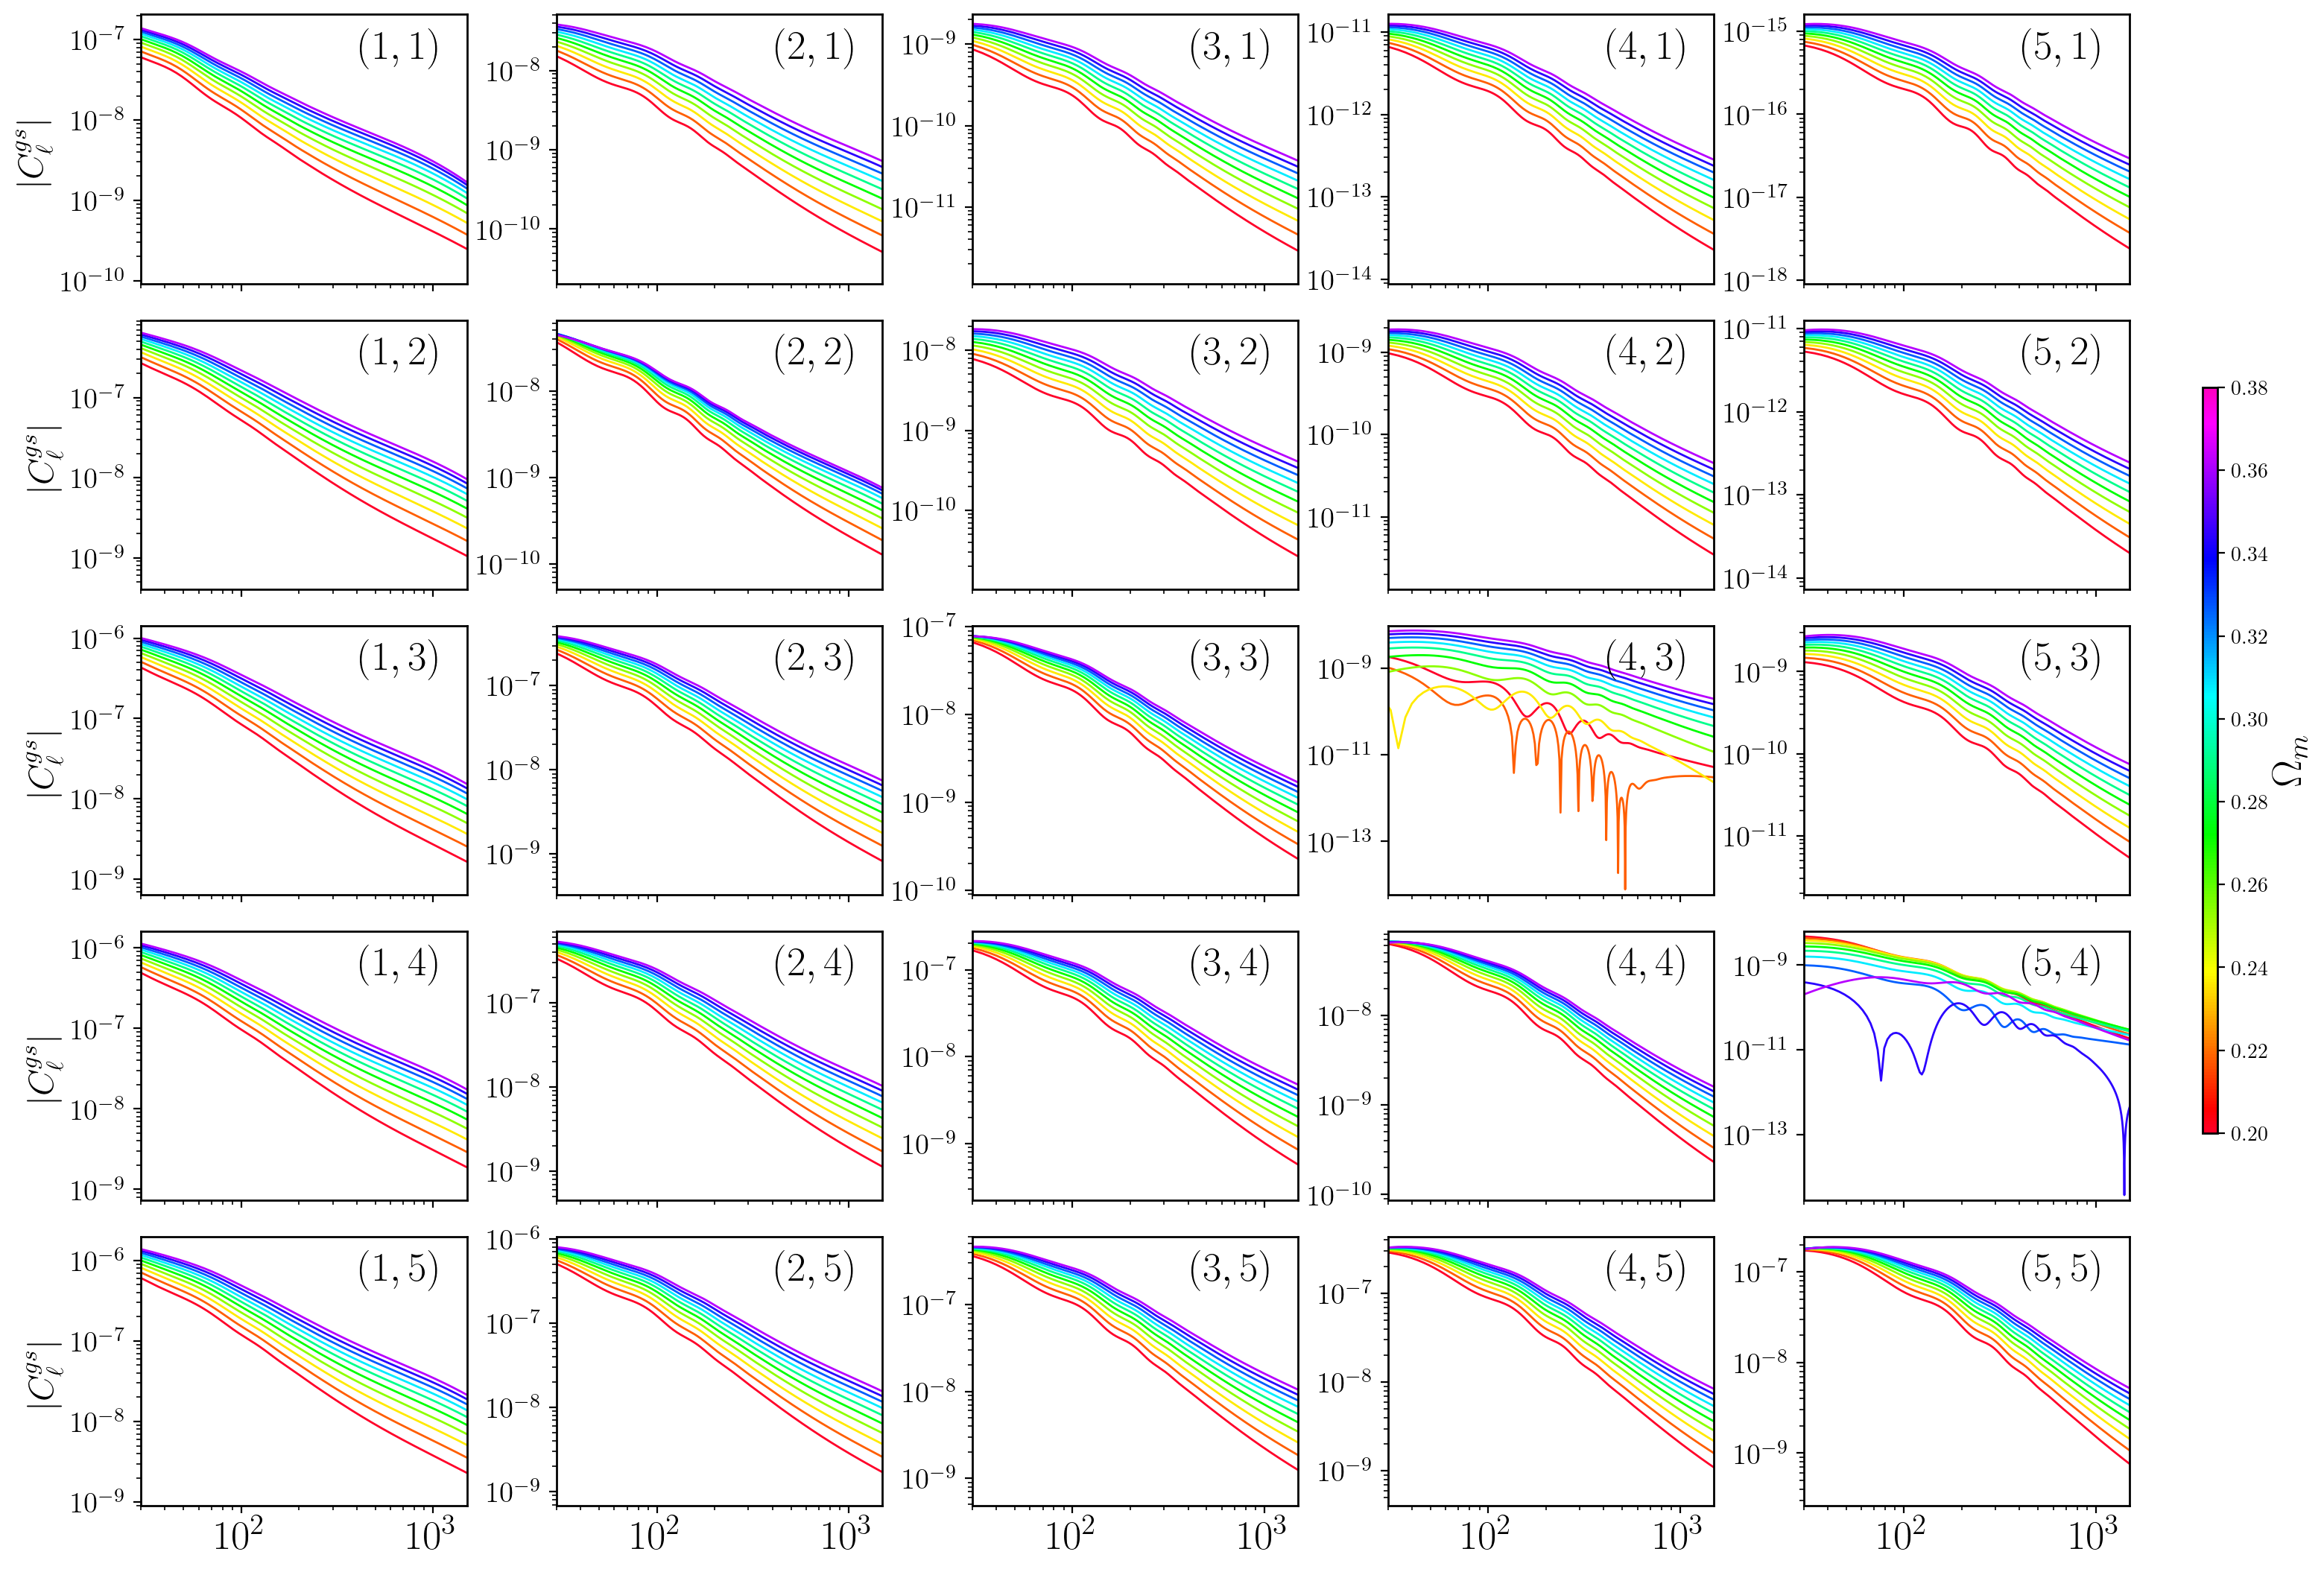

In [12]:
plot_C_gs_tomo_limber(ell=ell, C_gs=np.abs(C_gs), param=param, colorbarlabel="$\Omega_m$", bintextpos = [0.8, 0.875], ylim = [0.75,1.3],
                     figsize = (21, 13), bintextsize = 20,yaxislabelsize = 17,yaxisticklabelsize = 14, xaxisticklabelsize = 20)

In [13]:
ell = np.arange(25., 2500., 3.) # Make sure arange are with float numbers (otherwise there are aliasing problems)
param = np.arange(0.85, 1.1, 0.02)
C_gs = []
for x in param:
    C_gs.append(C_gs_tomo_limber(ell=ell, ns=x))

# Plot the Ratio over ref cosmology
ref = C_gs_tomo_limber(ell=ell)

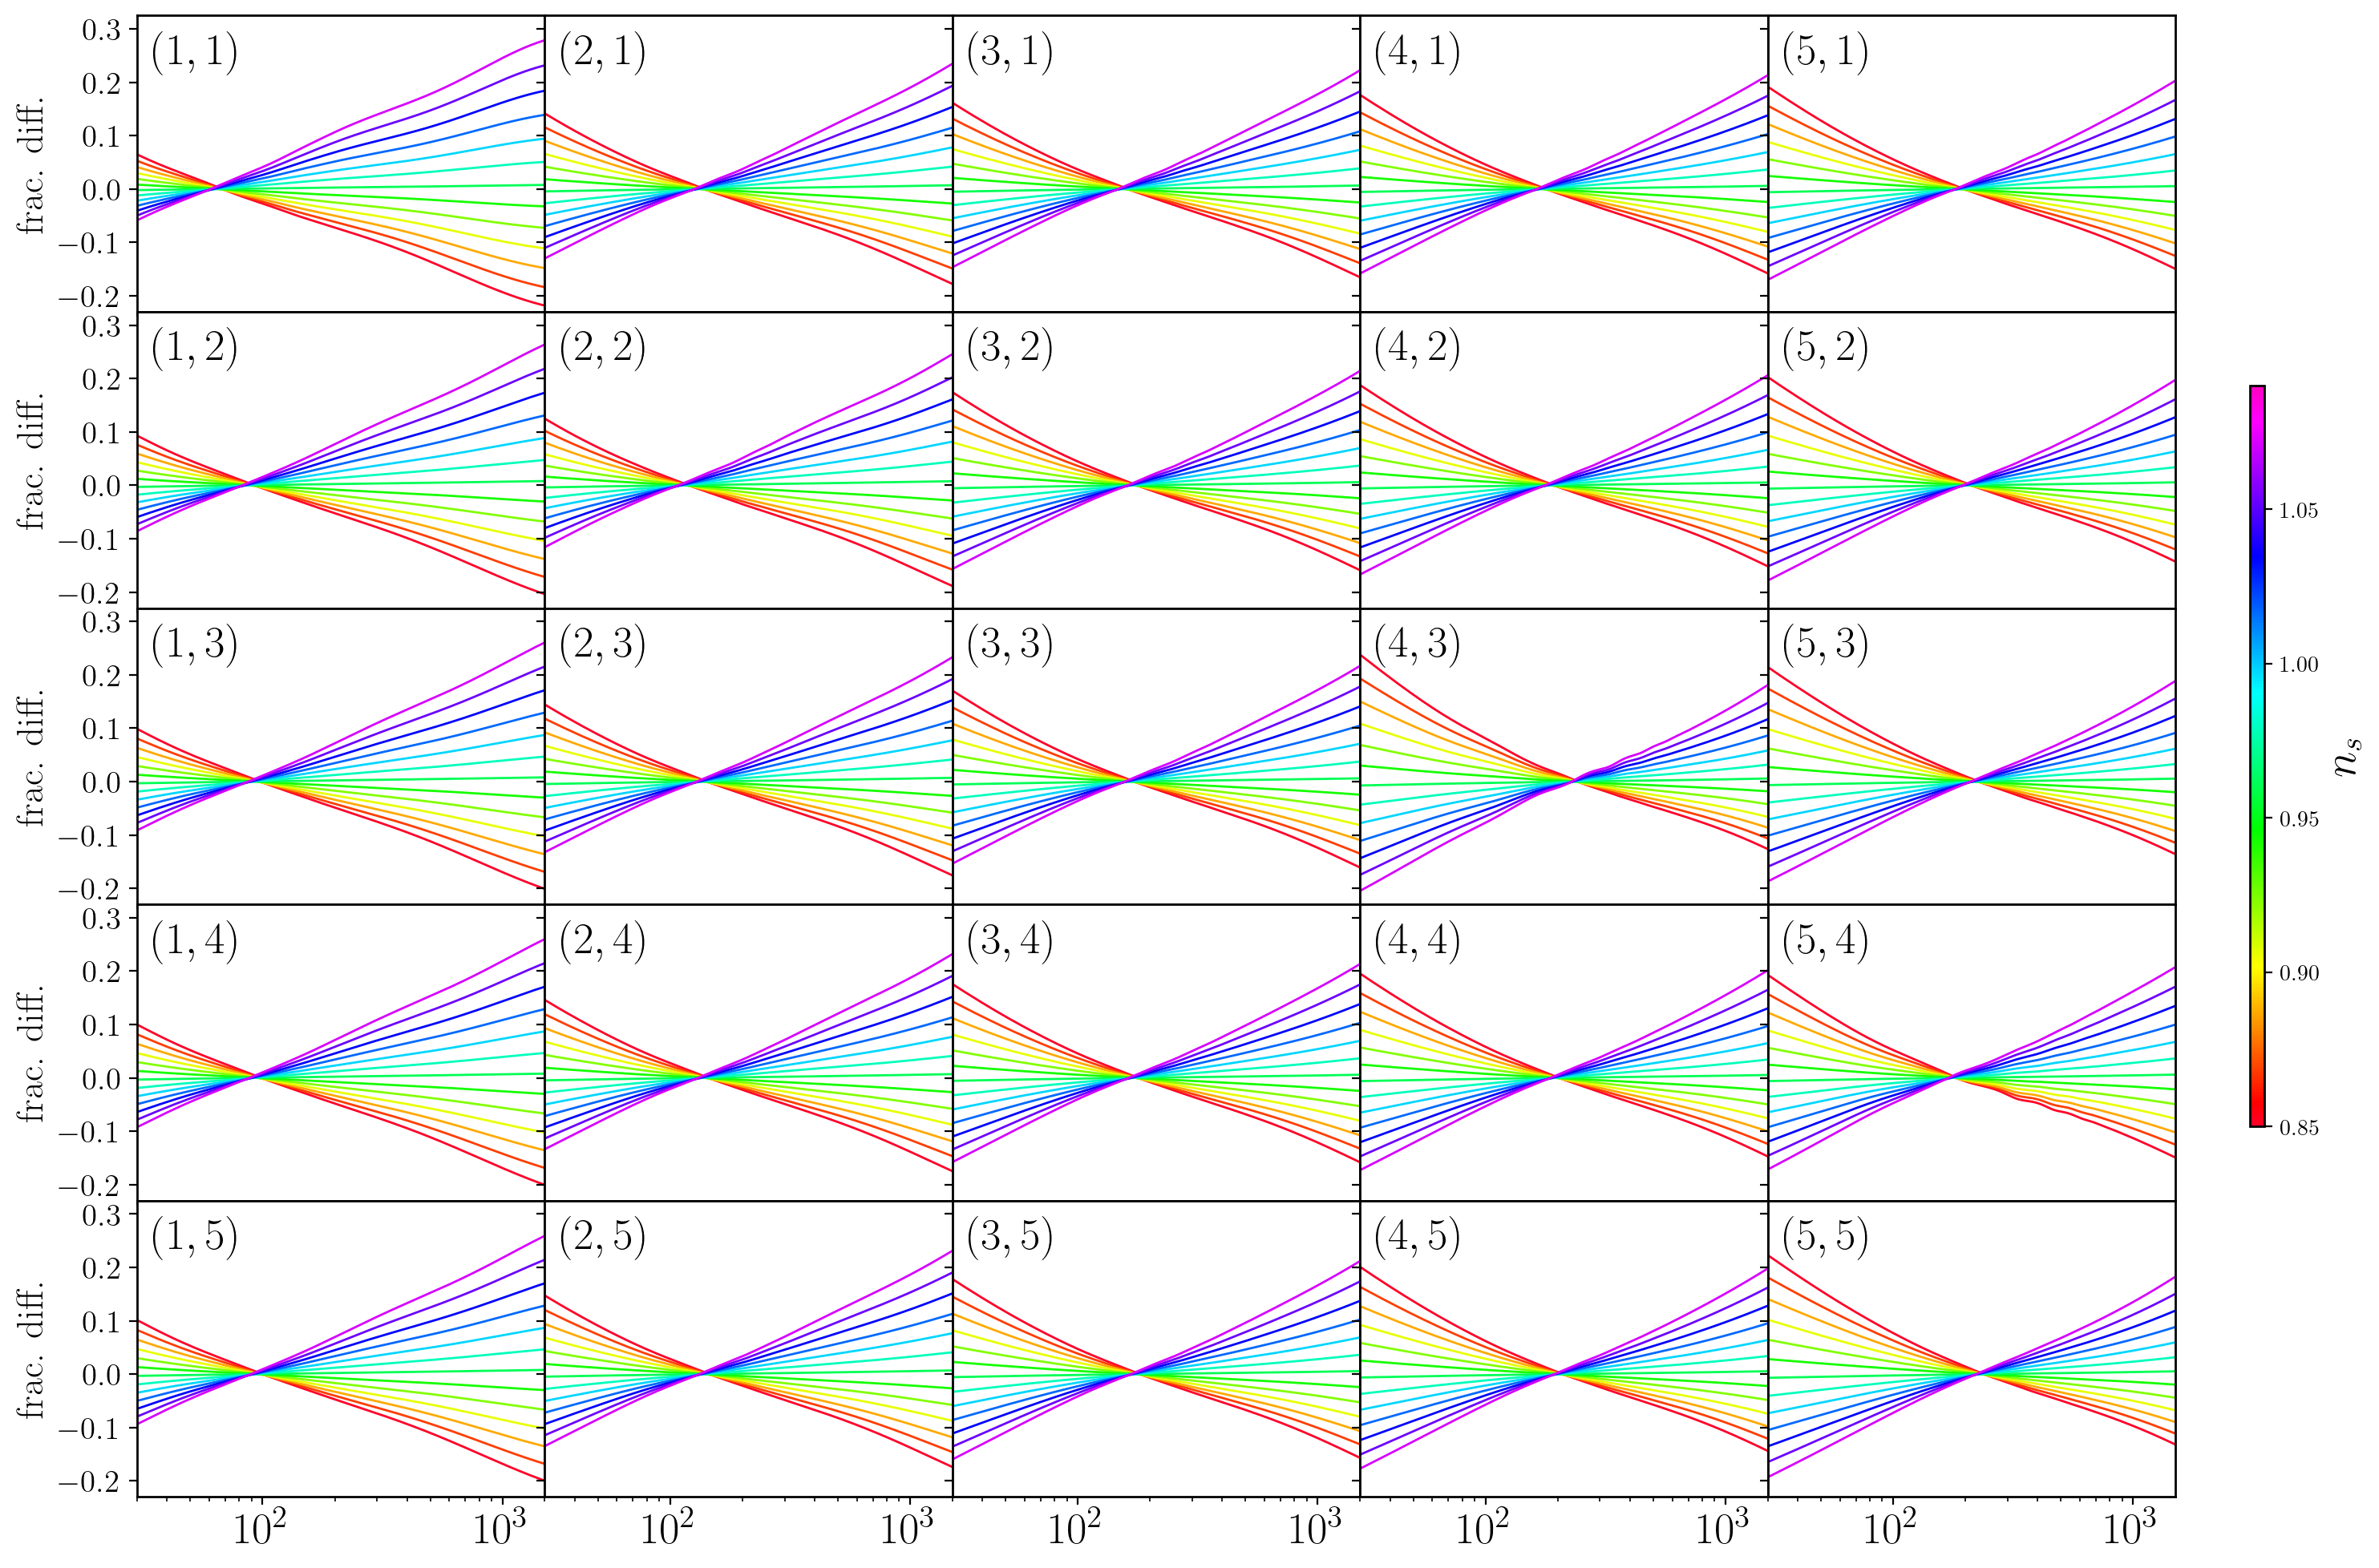

In [14]:
plot_C_gs_tomo_limber(ell=ell, C_gs=C_gs, C_gs_ref=ref, param=param, colorbarlabel="$n_s$", bintextpos = [0.15, 0.875], ylim = [0.77,1.325],
                     figsize = (20, 12), bintextsize = 20, yaxislabelsize = 17, yaxisticklabelsize = 14, xaxisticklabelsize = 20)

# Let's plot how cosmological and nuisance parameters affect $\gamma_t(\theta)$

In [15]:
param = np.arange(0.2, 0.4, 0.02)   
gammat_theta = []
for x in param:
    gammat_theta.append(gamma_t(omegam = x))

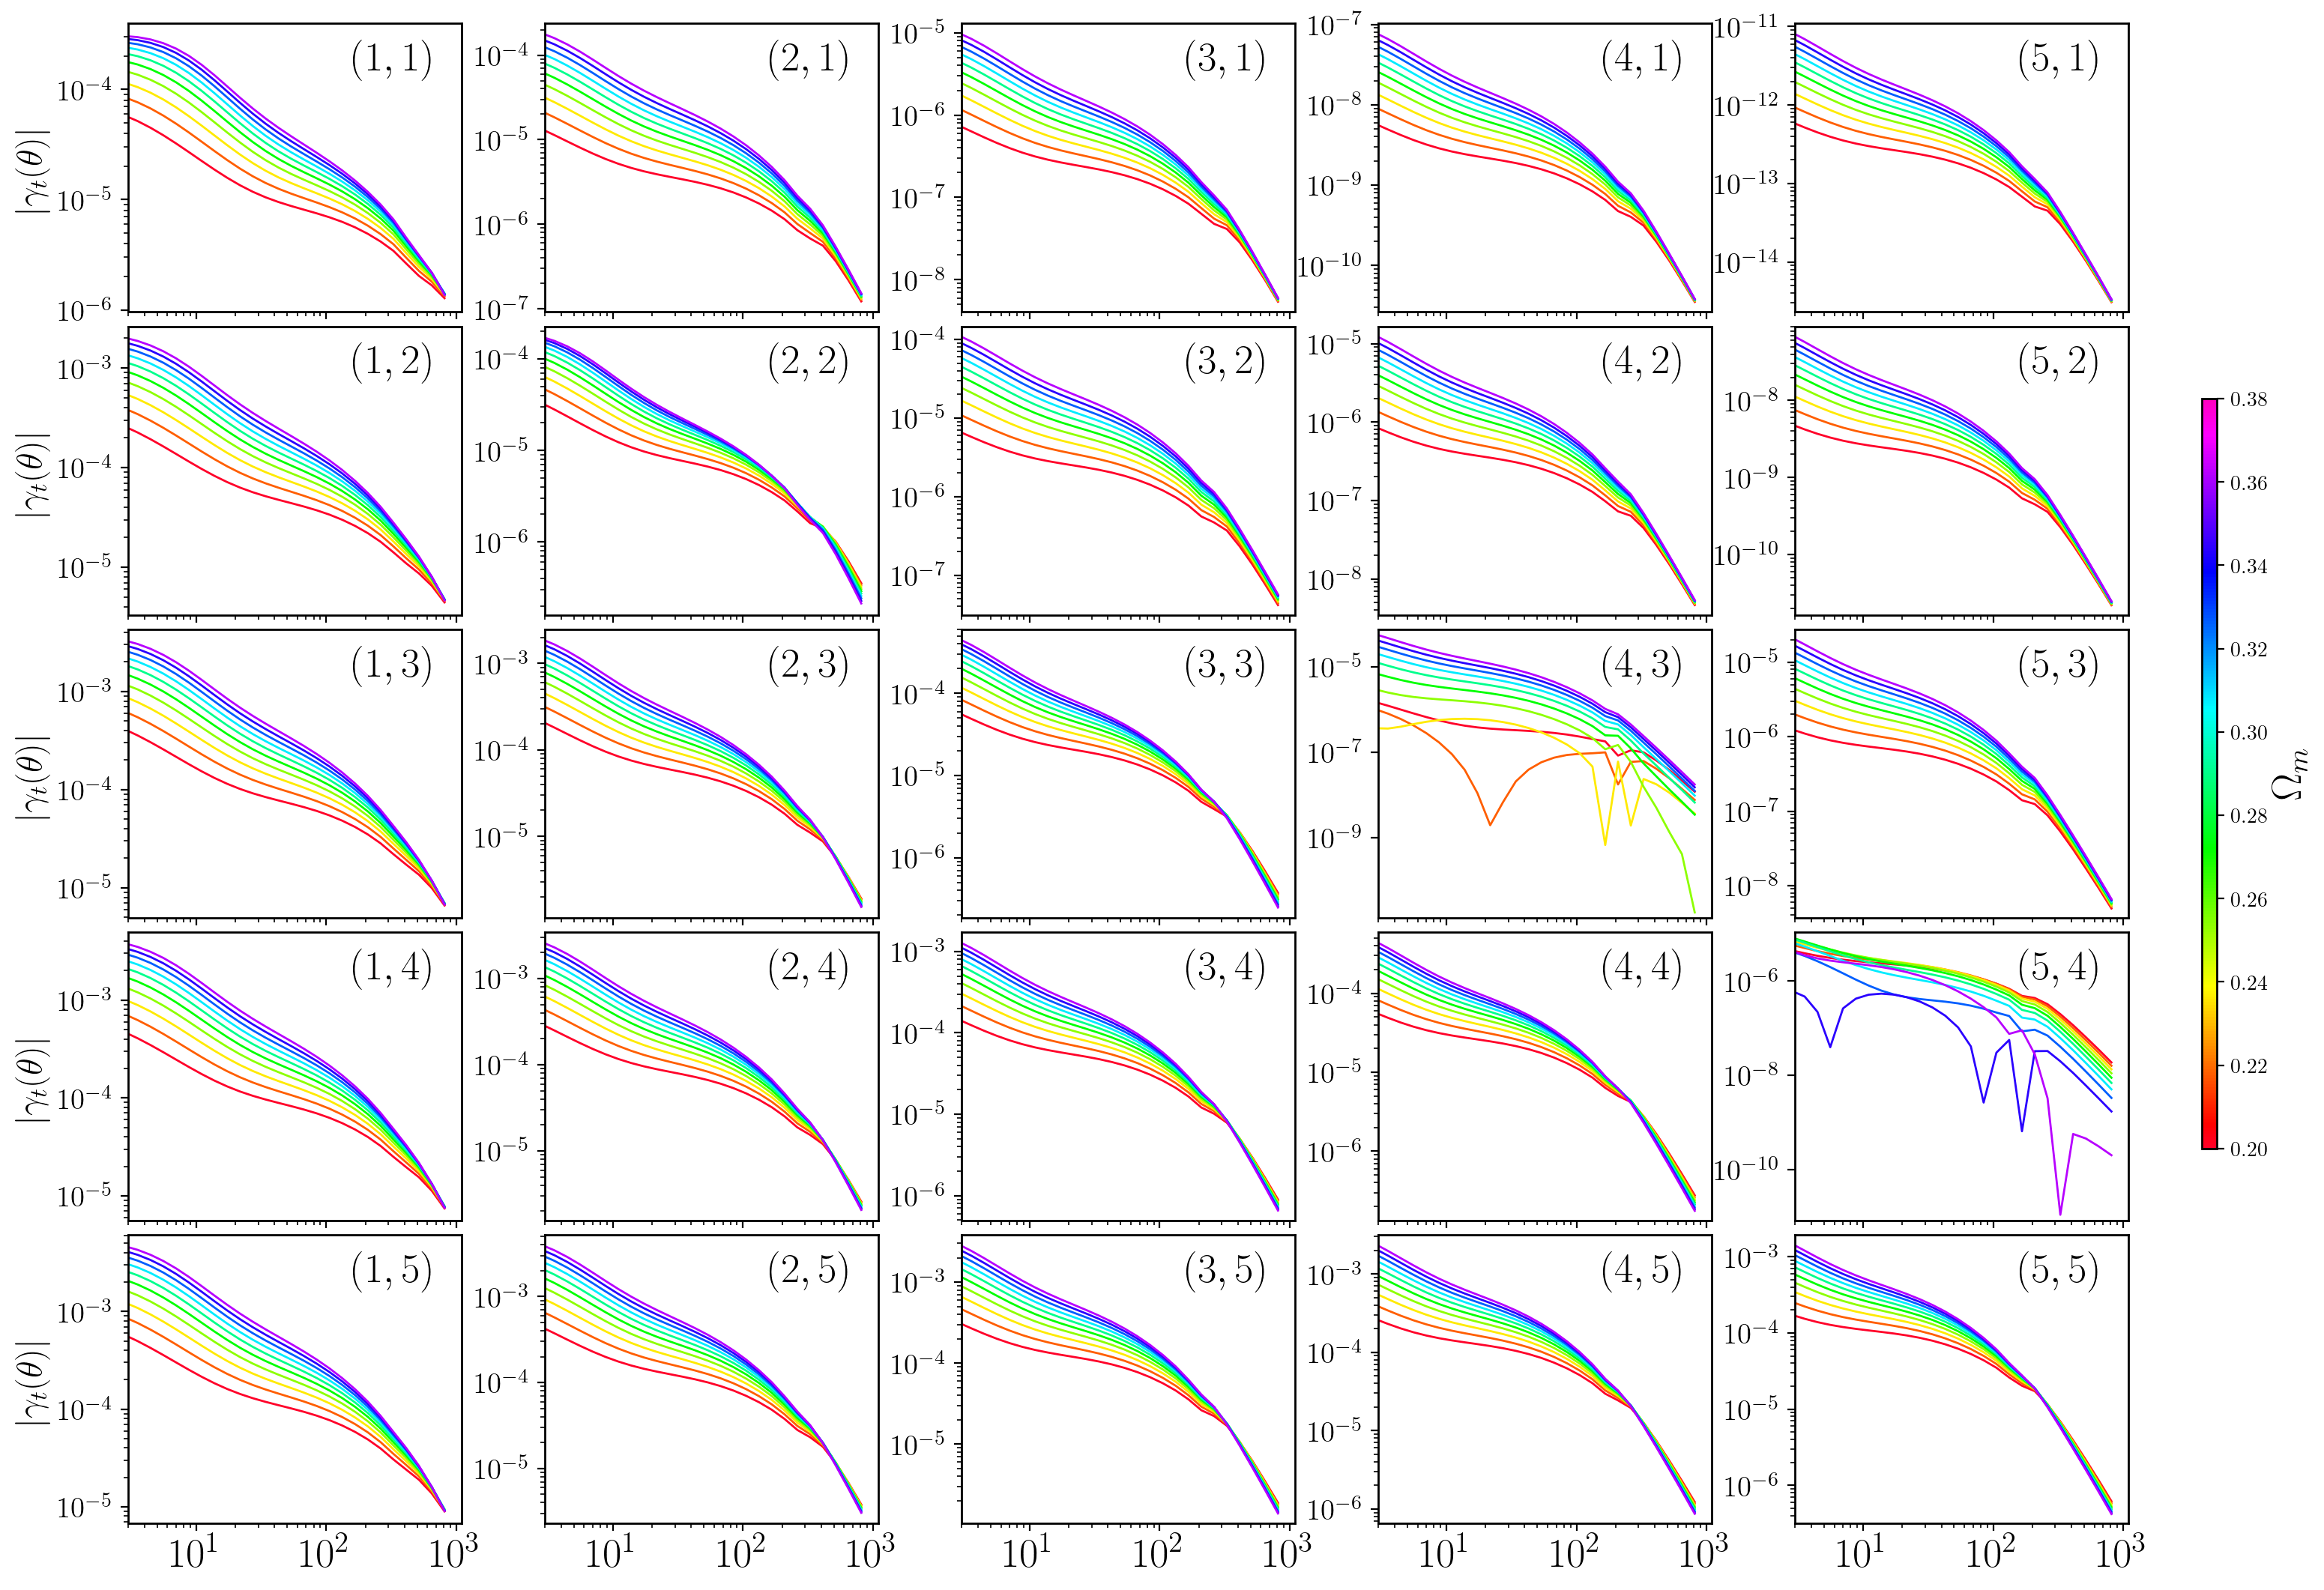

In [16]:
plot_gammat_tomo_limber(theta_gammat = gammat_theta, gammat_ref = None, param = param, colorbarlabel = "$\Omega_m$",
                       bintextpos = [0.8, 0.875], ylim = [0.75,1.3],
                       figsize = (21, 13), bintextsize = 20,yaxislabelsize = 17,yaxisticklabelsize = 14, xaxisticklabelsize = 20)

# Can we change the binning on $\gamma_t(\theta)$ w/o restarting the kernel? Yes!
Why this is a nontrivial question? Because Cosmolike uses static variables to cache internal variables

In [27]:
nthetas=[9, 12, 17, 44]
gammat_theta = []
for x in nthetas:
    gammat_theta.append(gamma_t(ntheta=x))

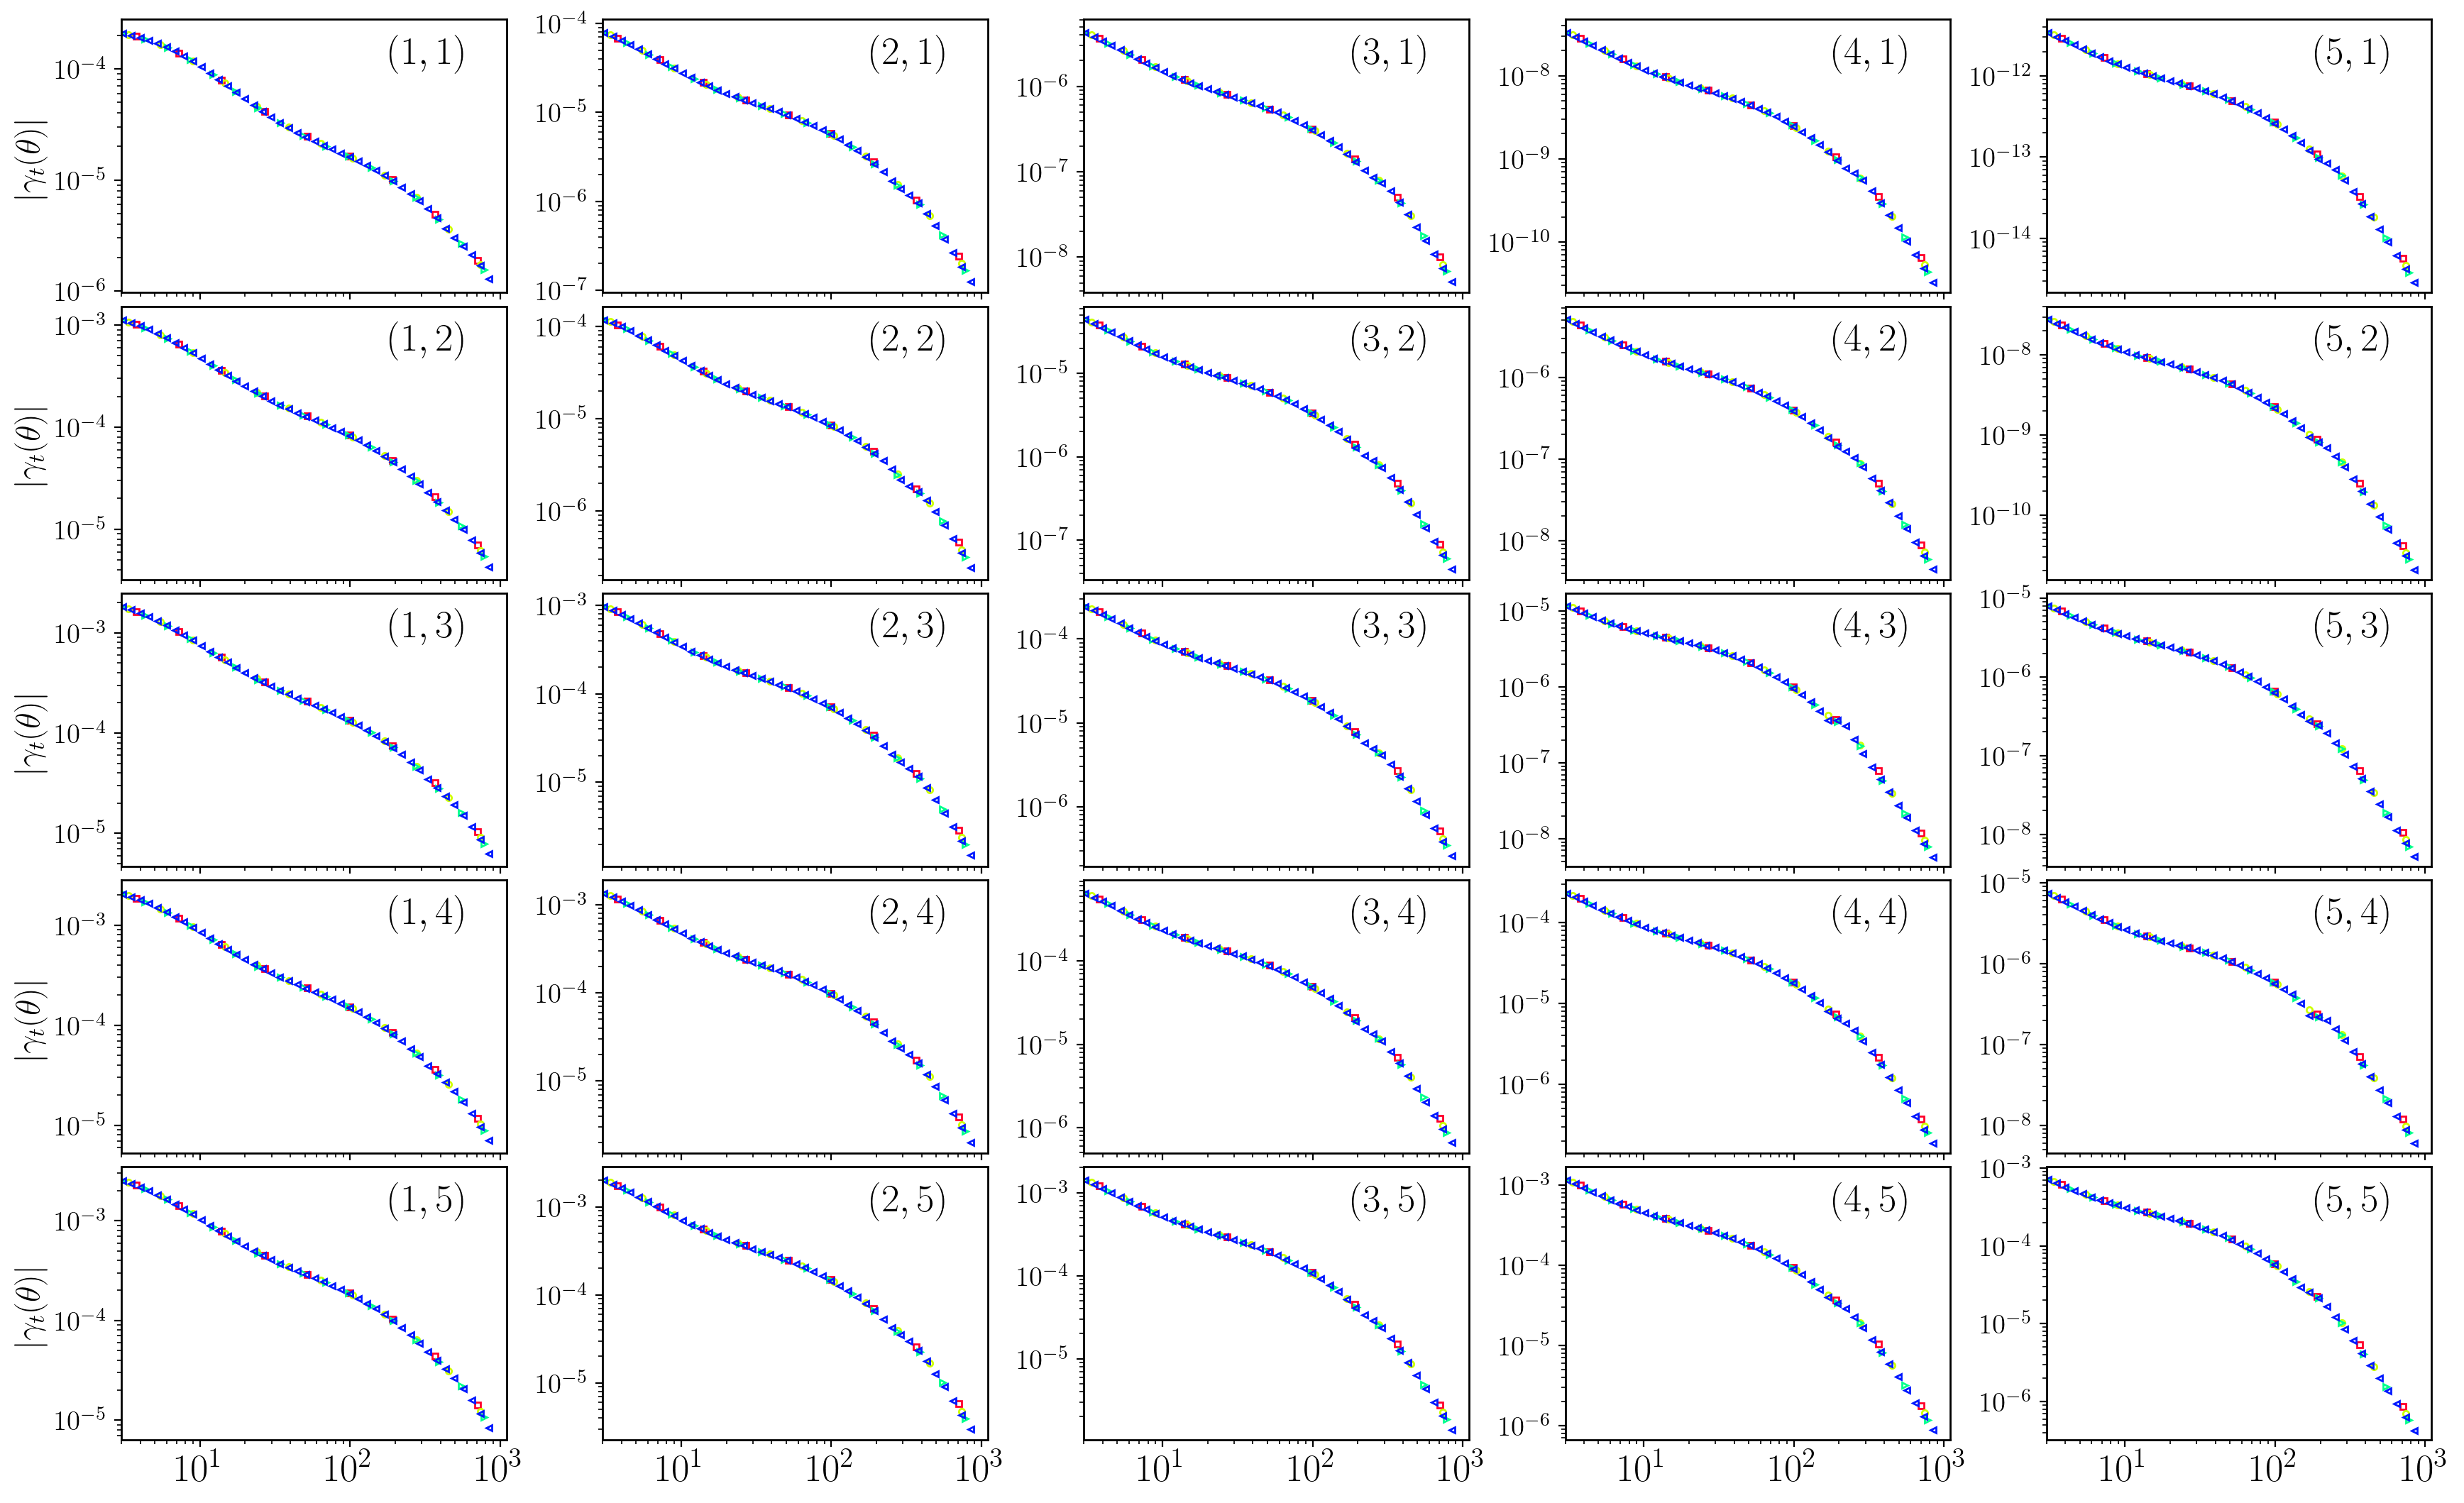

In [18]:
plot_gammat_tomo_limber(theta_gammat = gammat_theta, marker=['s', 'o', ">", "<"], ylim = [0.75,1.3], bintextpos = [0.8, 0.875],
                        figsize = (21, 13), bintextsize = 20,yaxislabelsize = 17,yaxisticklabelsize = 14, xaxisticklabelsize = 20)

# Add Baryon Contamination to $C_{\ell}^{gs}$ and $\gamma_t(\theta)$ data vectors

In [19]:
ell = np.arange(3., 7500., 10.) # Make sure np.arange are set w/ float numbers (otherwise there are aliasing problems)
param = ("TNG100-1", "HzAGN-1", "mb2-1", "illustris-1", "eagle-1", "owls_AGN-1", "owls_AGN-2", "owls_AGN-3", "BAHAMAS-2")
    
C_gs = []
for x in param:
    C_gs.append(C_gs_tomo_limber(ell=ell,baryon_sims=x))
    
# Plot the Ratio over ref cosmology
C_gs_ref = C_gs_tomo_limber(ell=ell)

gammat_theta = []
for x in param:
    gammat_theta.append(gamma_t(baryon_sims=x, ntheta=40, AccuracyBoost=1.0))
gammat_theta_ref = gamma_t(ntheta=40, AccuracyBoost=1.0)

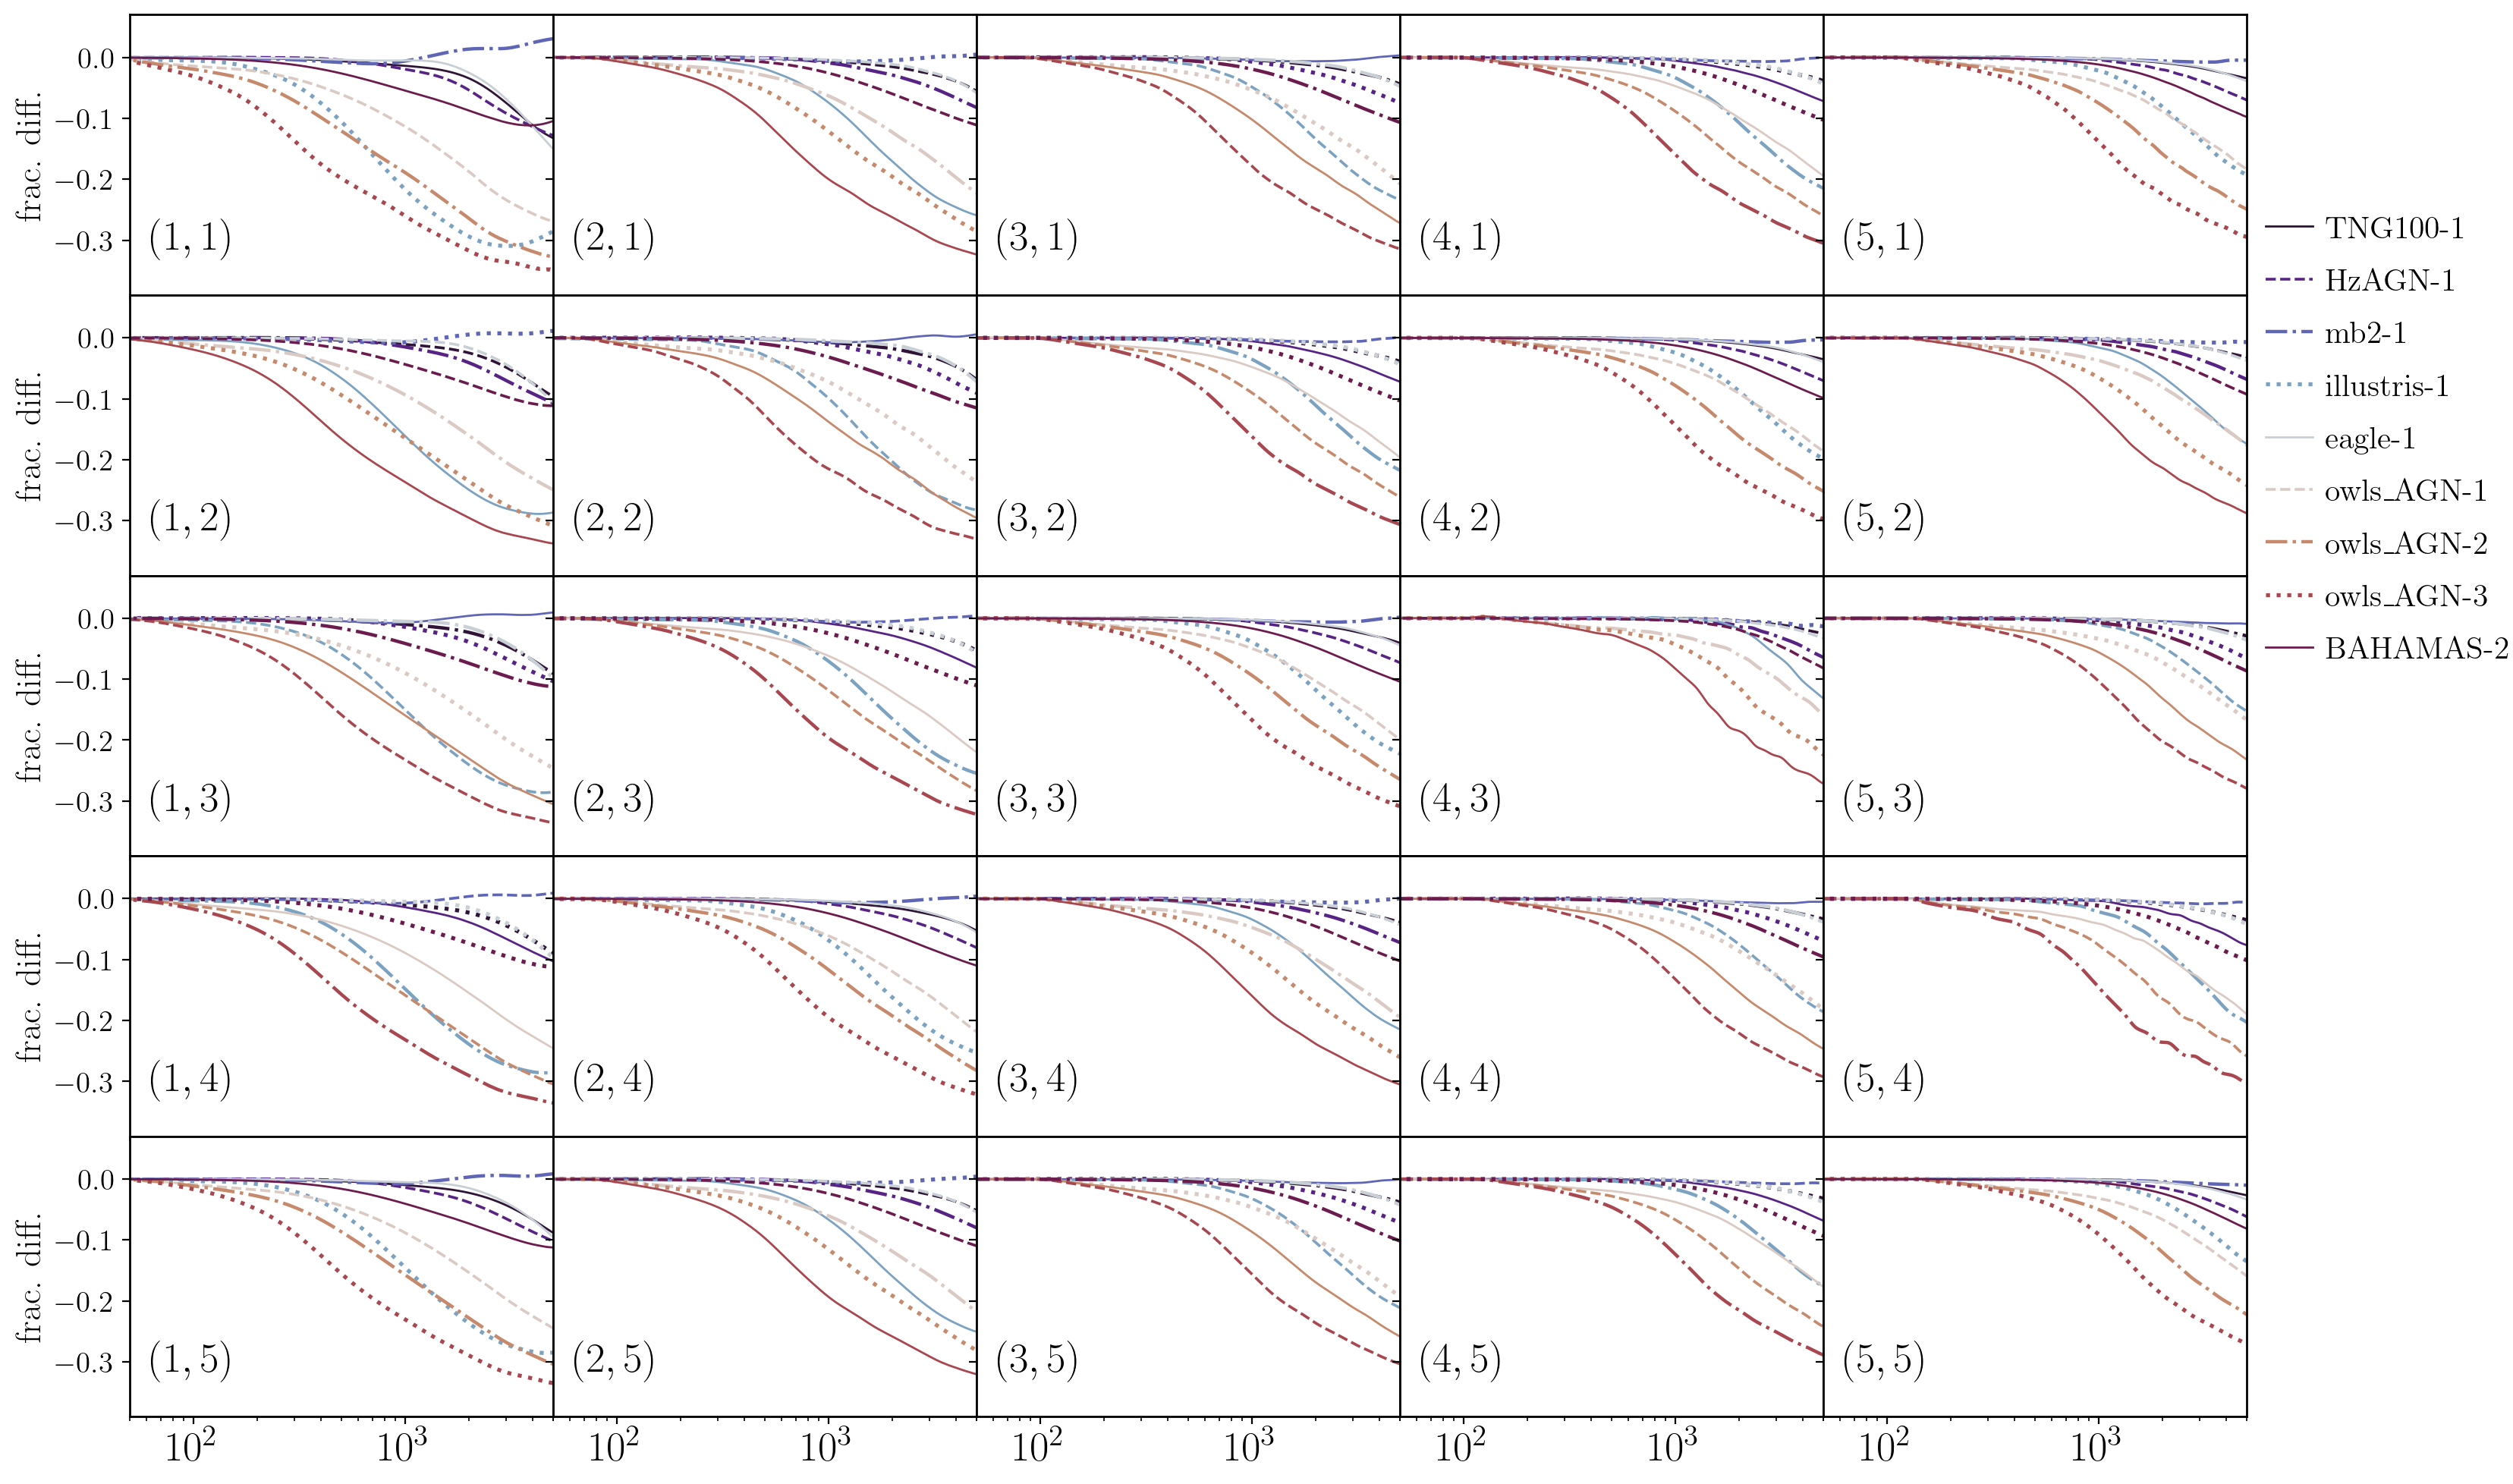

In [20]:
matplotlib.rcParams['legend.fontsize'] = 15
plot_C_gs_tomo_limber(ell=ell, C_gs=C_gs, C_gs_ref=C_gs_ref, lmin=50, lmax=5000, cmap="twilight_shifted", 
                      bintextpos = [0.15, 0.2], ylim = [0.61,1.07], legend = param, legendloc=(0.9,0.55),
                      linewidth=[1.0, 1.3, 1.6, 1.9], linestyle = ['solid', 'dashed', 'dashdot', 'dotted'],
                      figsize = (18, 12), bintextsize = 20, yaxislabelsize = 17, yaxisticklabelsize = 14, xaxisticklabelsize = 20)

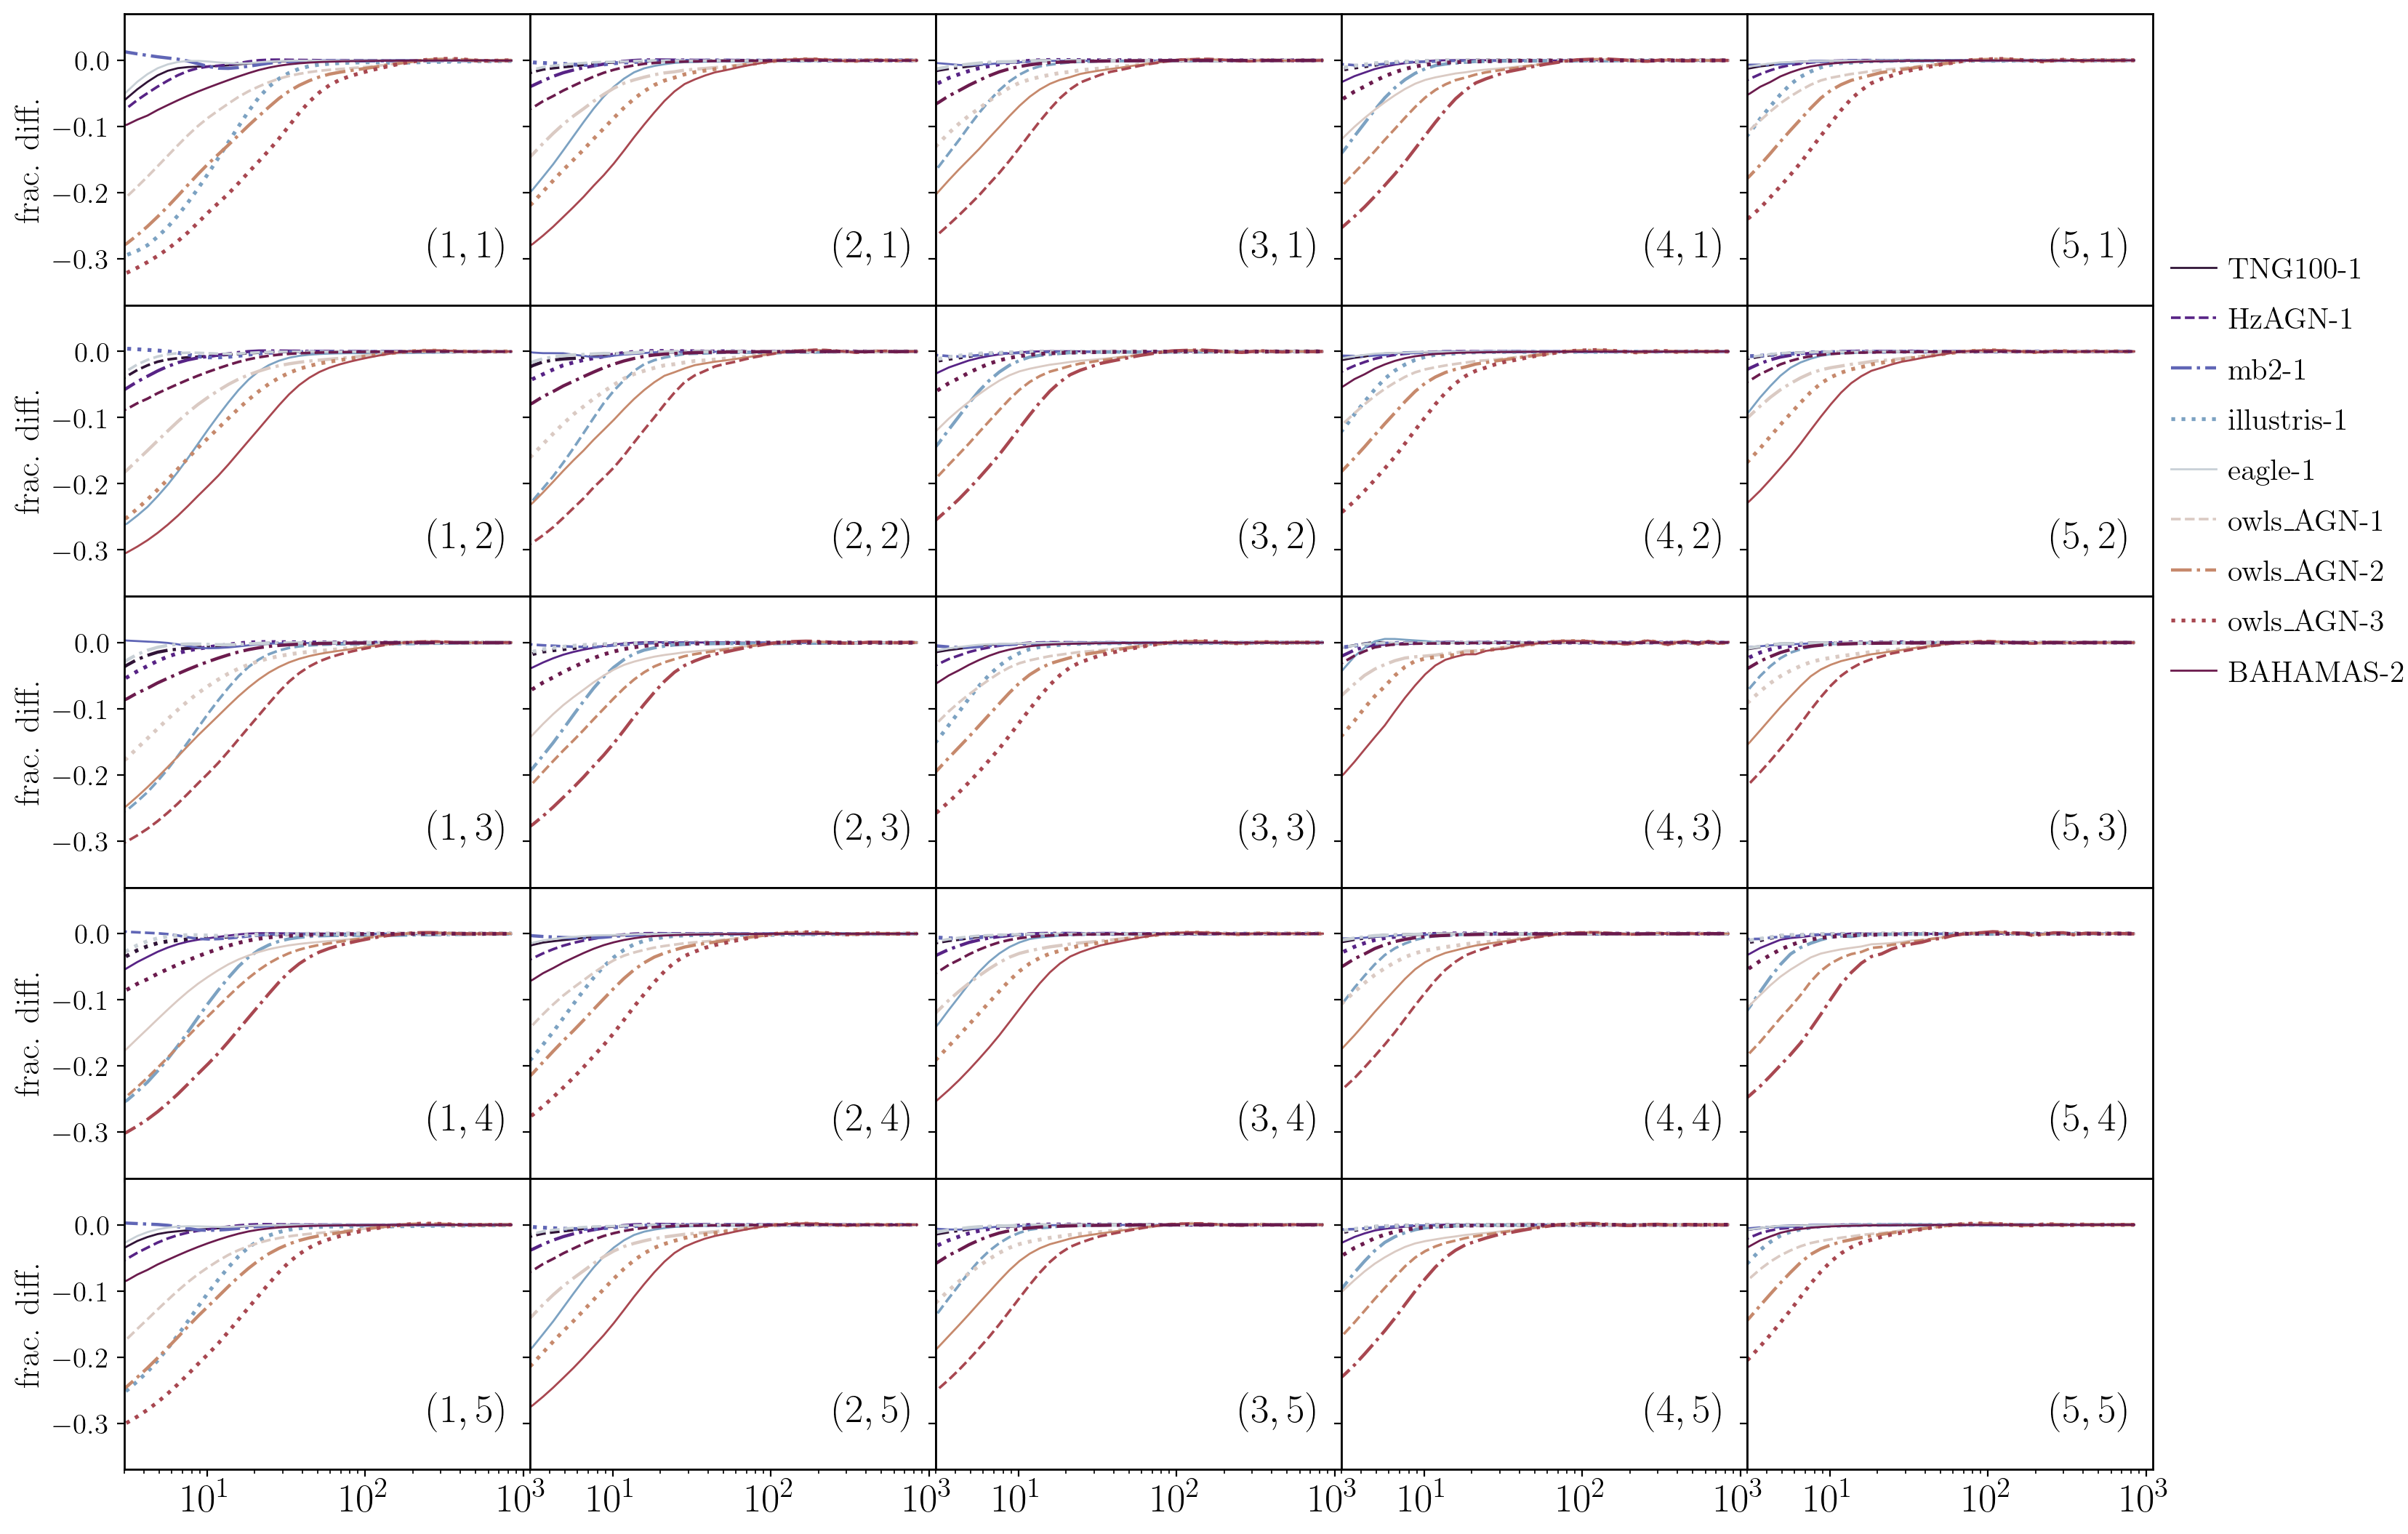

In [21]:
plot_gammat_tomo_limber(theta_gammat=gammat_theta, gammat_ref=gammat_theta_ref,cmap="twilight_shifted",
                       bintextpos = [0.85, 0.2], ylim = [0.63,1.07], legend = param, legendloc=(0.9,0.55),
                       linewidth=[1.0, 1.3, 1.6, 1.9], linestyle = ['solid', 'dashed', 'dashdot', 'dotted'],
                       figsize = (18, 13), bintextsize = 20,yaxislabelsize = 17,yaxisticklabelsize = 14, xaxisticklabelsize = 20)

# Check how CAMB and Cosmolike Accuracy Boost affect $C_\ell^{\rm gs}$ and $\gamma_t(\theta)$ data vectors

In [22]:
ell = np.arange(10., 8500., 30.) # Make sure np.arange are set w/ float numbers (otherwise there are aliasing problems)

param = np.arange(0.6, 2.0, 0.2)

C_gs = []
for x in param:
    C_gs.append(C_gs_tomo_limber(ell=ell,AccuracyBoost=x))
    
# Plot the Ratio over ref cosmology
C_gs_ref = C_gs_tomo_limber(ell=ell)

gammat_theta = []
for x in param:
    gammat_theta.append(gamma_t(ntheta=40, AccuracyBoost=x))
gammat_theta_ref = gamma_t(ntheta=40, AccuracyBoost=1.0)

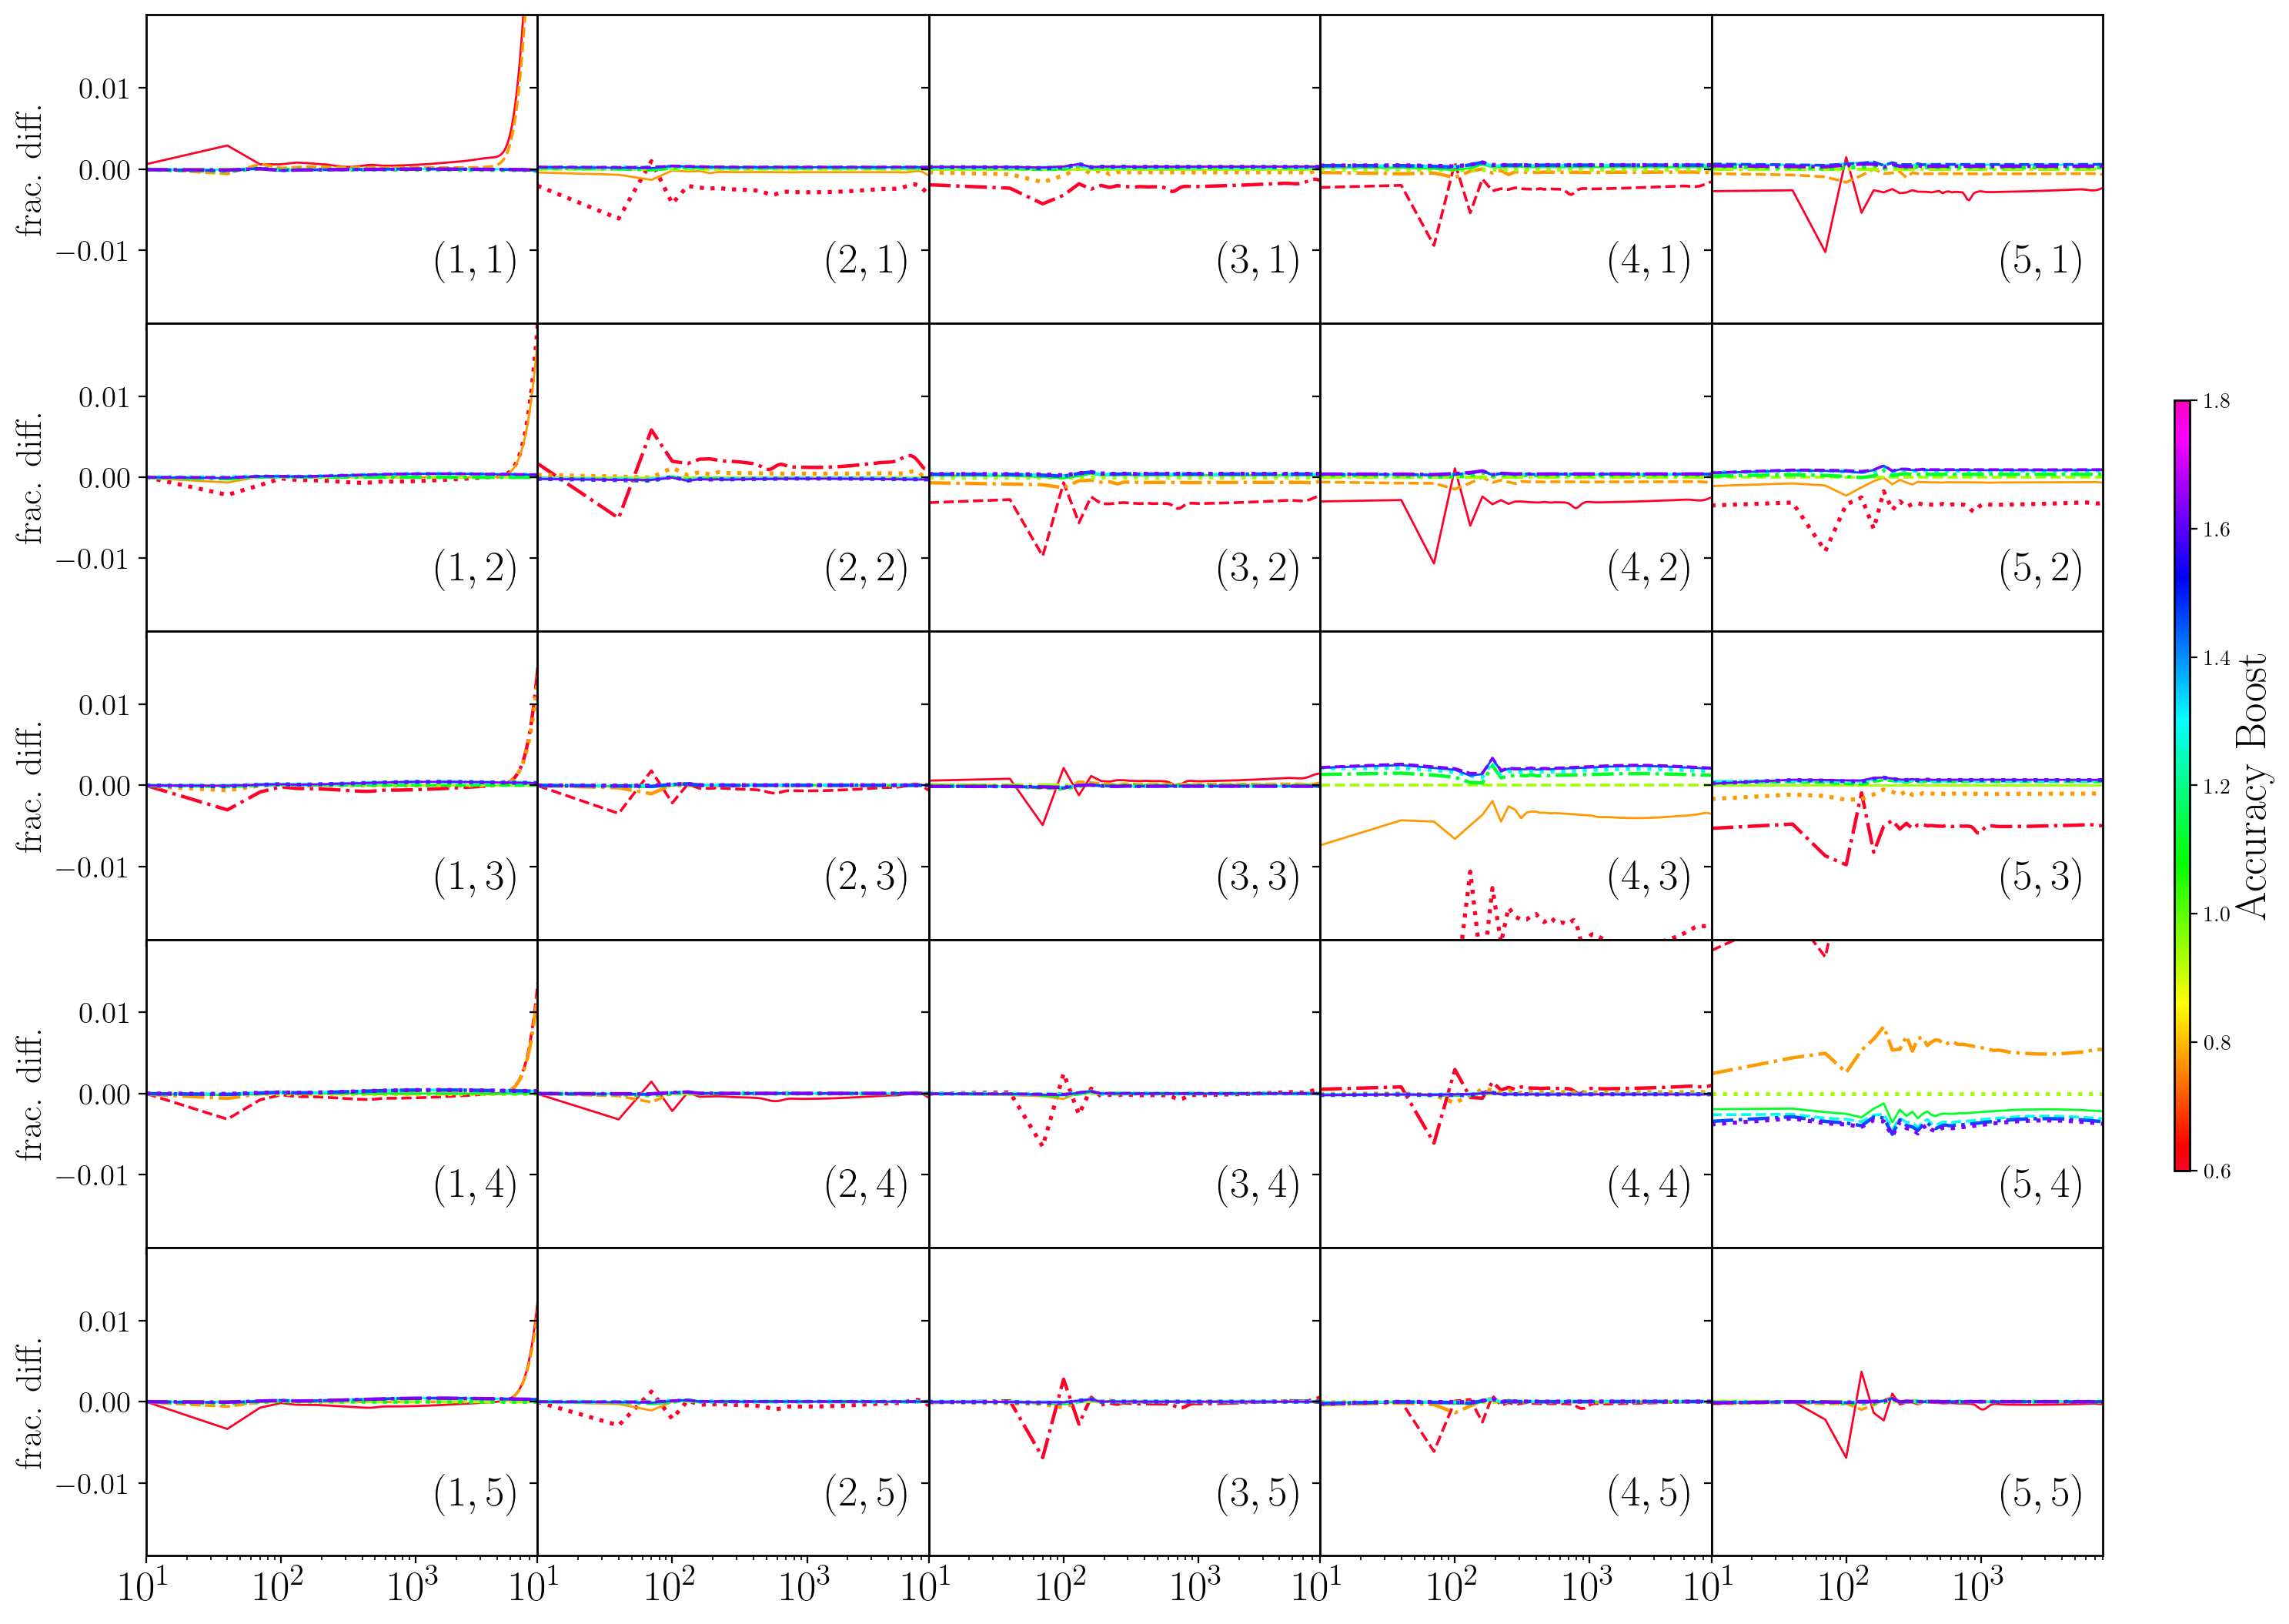

In [23]:
plot_C_gs_tomo_limber(ell=ell, C_gs=C_gs, C_gs_ref=C_gs_ref, param=param, lmin=10, lmax=8000, ylim=(0.981,1.019), bintextpos = [0.85, 0.2],
                      colorbarlabel="Accuracy Boost", linewidth=[1.0, 1.3, 1.6, 1.9], linestyle = ['solid', 'dashed', 'dashdot', 'dotted'],
                      figsize = (20, 13), bintextsize = 20, yaxislabelsize = 17, yaxisticklabelsize = 14, xaxisticklabelsize = 20)

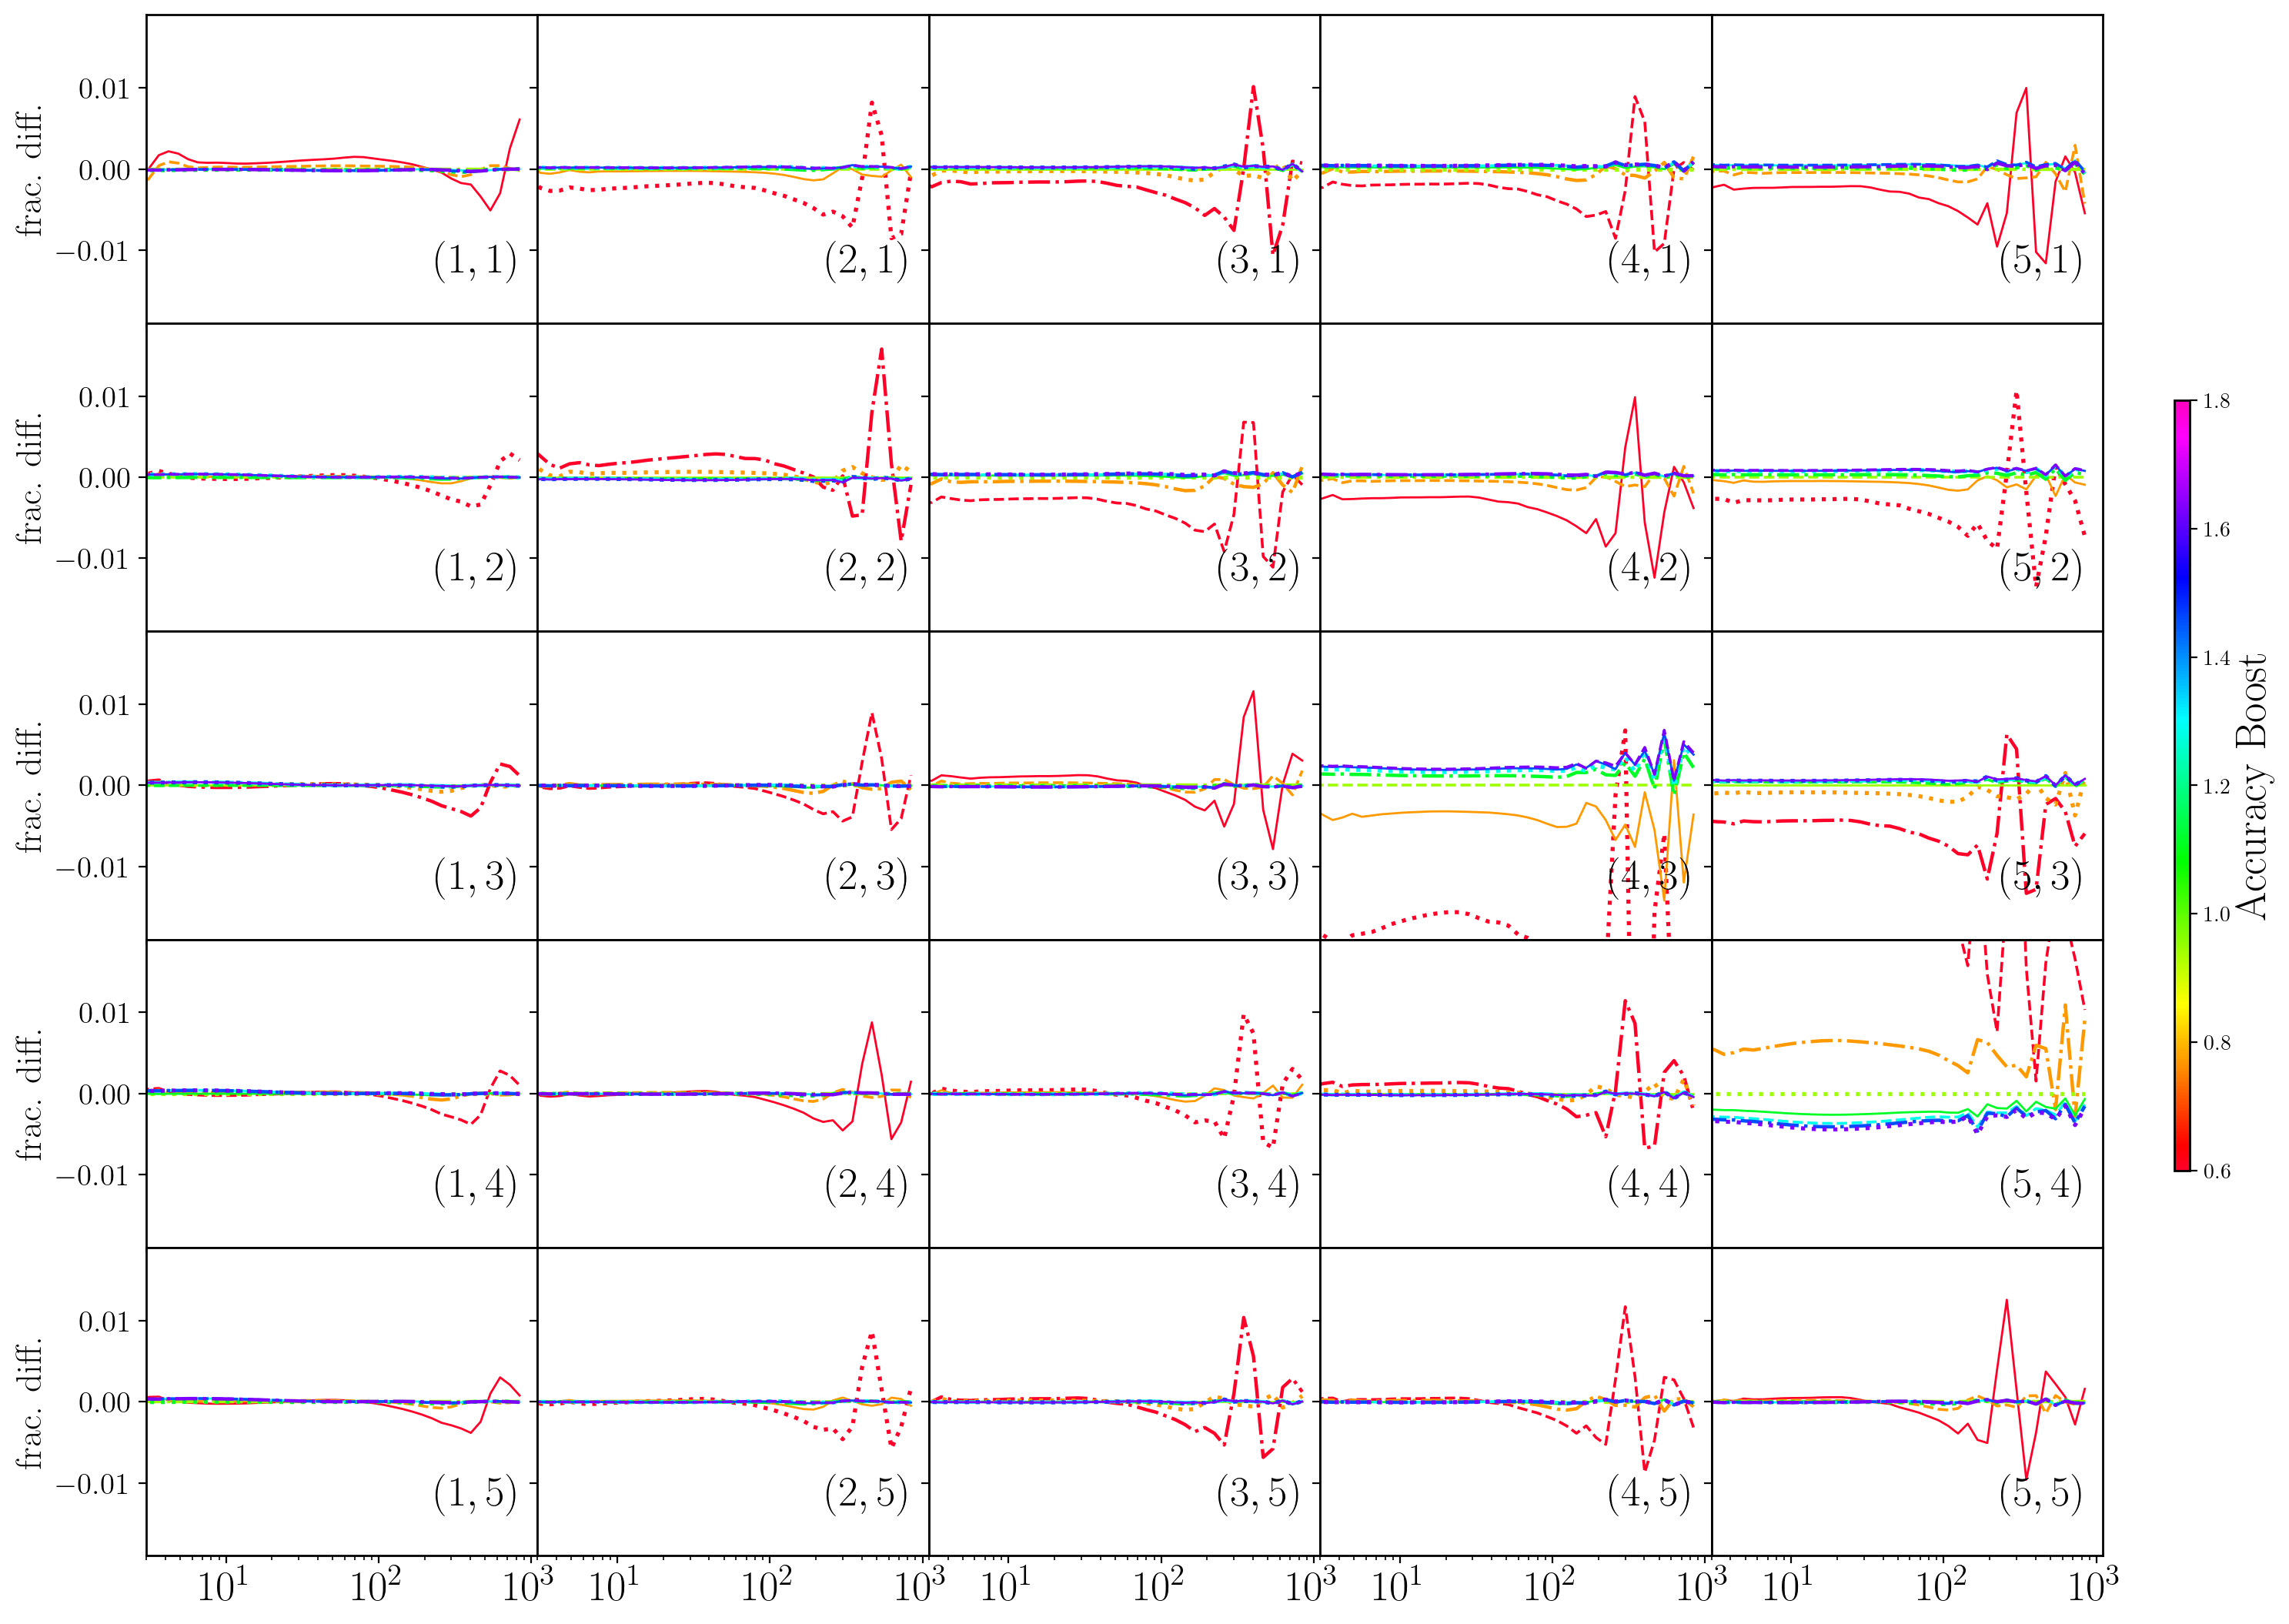

In [24]:
plot_gammat_tomo_limber(theta_gammat=gammat_theta, gammat_ref=gammat_theta_ref,
                       bintextpos = [0.85, 0.2], ylim = (0.981,1.019), param=param, legendloc=(0.9,0.55), colorbarlabel="Accuracy Boost",
                       linewidth=[1.0, 1.3, 1.6, 1.9], linestyle = ['solid', 'dashed', 'dashdot', 'dotted'],
                       figsize = (20, 13), bintextsize = 20,yaxislabelsize = 17,yaxisticklabelsize = 14, xaxisticklabelsize = 20)

## Let's compute $\chi^2_{\rm LSST}$ and reproduce the results shown on EXAMPLE_EVALUATE2.YAML

In [25]:
CLprobe="3x2pt"
path= "../../external_modules/data/lsst_y1"
data_file="lsst_y1_M1_GGL0.05.dataset"

IA_model = 0
IA_redshift_evolution = 3

ntheta = 26 
theta_min_arcmin = 2.5 
theta_max_arcmin = 900

ini = IniFile(os.path.normpath(os.path.join(path, data_file)))

ci.initial_setup()

ci.init_accuracy_boost(1.0, 1.0, int(1))

ci.init_probes(possible_probes = CLprobe)

ci.init_binning(int(ini.int("n_theta")), 
                ini.float("theta_min_arcmin"), 
                ini.float("theta_max_arcmin"))

ci.init_cosmo_runmode(is_linear = False)

ci.init_IA( ia_model = int(IA_model), 
            ia_redshift_evolution = int(IA_redshift_evolution))

ci.init_redshift_distributions_from_files(
      lens_multihisto_file=ini.relativeFileName('nz_lens_file'),
      lens_ntomo=int(ini.int("lens_ntomo")), 
      source_multihisto_file=ini.relativeFileName('nz_source_file'),
      source_ntomo=int(ini.int("source_ntomo")))

ci.init_data_real(ini.relativeFileName('cov_file'), 
                  ini.relativeFileName('mask_file'), 
                  ini.relativeFileName('data_file'))

if CLprobe != "xi":
    ci.init_bias(bias_model=[0,0,0,1,0])

def get_chi2(omegam = omegam, 
             omegab = omegab, 
             H0 = H0, 
             ns = ns, 
             As_1e9 = As_1e9, 
             w = w, 
             w0pwa = w0pwa,
             A1  = [LSST_A1_1, LSST_A1_2, 0, 0, 0], 
             A2  = [0, 0, 0, 0, 0],
             BTA = [0, 0, 0, 0, 0],
             shear_photoz_bias = [LSST_DZ_S1, LSST_DZ_S2, LSST_DZ_S3, LSST_DZ_S4, LSST_DZ_S5],
             M = [LSST_M1, LSST_M2, LSST_M3, LSST_M4, LSST_M5],
             lens_photoz_bias = [LSST_DZ_L1, LSST_DZ_L2, LSST_DZ_L3, LSST_DZ_L4, LSST_DZ_L5],
             galaxy_bias_b1 = [LSST_B1_1, LSST_B1_2, LSST_B1_3, LSST_B1_4, LSST_B1_5],
             galaxy_bias_b2 = [0,0,0,0,0],
             galaxy_bias_bmag = [0,0,0,0,0],
             PM = [LSST_PM_1, LSST_PM_2, LSST_PM_3, LSST_PM_4, LSST_PM_5],
             baryon_sims = None,
             AccuracyBoost=1.0, 
             kmax = 10, 
             k_per_logint = 20, 
             CAMBAccuracyBoost=1.1,
             CLAccuracyBoost=1.0, 
             CLIntegrationAccuracy = 0):

    # Set Nuisance Parameters
    (log10k_interp_2D, z_interp_2D, lnPL, lnPNL, G_growth, z_interp_1D, chi) = get_camb_cosmology(omegam=omegam, 
        omegab=omegab, H0=H0, ns=ns, As_1e9=As_1e9, w=w, w0pwa=w0pwa, AccuracyBoost=AccuracyBoost, kmax=kmax,
        k_per_logint=k_per_logint, CAMBAccuracyBoost=CAMBAccuracyBoost)
    
    ci.set_cosmology(omegam = omegam, 
                     H0 = H0, 
                     log10k_2D = log10k_interp_2D, 
                     z_2D = z_interp_2D, 
                     lnP_linear = lnPL,
                     lnP_nonlinear = lnPNL,
                     G = G_growth,
                     z_1D = z_interp_1D,
                     chi = chi)

    ci.set_nuisance_bias(B1 = [LSST_B1_1, LSST_B1_2, LSST_B1_3, LSST_B1_4, LSST_B1_5],
                         B2 = [0,0,0,0,0],
                         B_MAG = [0,0,0,0,0])

    ci.set_nuisance_clustering_photoz(bias = [LSST_DZ_L1, LSST_DZ_L2, LSST_DZ_L3, LSST_DZ_L4, LSST_DZ_L5])

    ci.set_point_mass(PMV=PM)
    
    ci.set_nuisance_shear_calib(M = [LSST_M1, LSST_M2, LSST_M3, LSST_M4, LSST_M5])

    ci.set_nuisance_shear_photoz(bias = [LSST_DZ_S1, LSST_DZ_S2, LSST_DZ_S3, LSST_DZ_S4, LSST_DZ_S5])

    ci.set_nuisance_ia(A1 = [LSST_A1_1, LSST_A1_2, 0, 0, 0], 
                       A2 = [0, 0, 0, 0, 0], 
                       B_TA = [0, 0, 0, 0, 0])

    datavector = np.array(ci.compute_data_vector_masked())
    return ci.compute_chi2(datavector)

In [26]:
print(rf"$\chi^2$={get_chi2():3.3f}")

$\chi^2$=0.261


# Let's plot how cosmological and nuisance parameters affect $C_{\ell}^{gg}$

# Let's plot how cosmological and nuisance parameters affect $w(\theta)$

# Can we change the binning on $w(\theta)$ w/o restarting the kernel? Yes!
Why this is a nontrivial question? Because Cosmolike uses static variables to cache internal variables